# Introduction
This notebook shows the steps we went through to find load, clean, apply feature engineering, transform, and model 2 datasets we combined. The purpose of this project is to be able to predict how popular a given song will be using features found in a Spotify Top 30,000 songs database.

## Load and Prepare Dataset

### Dataset Loading
The main dataset containing Spotify song data and an auxiliary dataset with artist metadata were loaded. These datasets were combined for additional artist-level information.

### Dataset Merging
Artist names in both datasets were standardized (lowercase and whitespace removed) to enable proper merging. The datasets were then merged using a left join on the artist name, retaining all songs and appending artist metadata.




In [1]:
!pip install tensorflow

In [2]:
!pip install scikeras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, XGBRegressor
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Mount and read drive
from google.colab import drive
drive.mount('/content/drive')

# Main dataset
df = pd.read_csv('/content/drive/MyDrive/BU/Fall 2024/BA476/BA476 Final Project/Data set/spotify_songs.csv')

# Dataset for artist index
artist_metadata_df = pd.read_csv('/content/drive/MyDrive/BU/Fall 2024/BA476/BA476 Final Project/Data set/top10k-spotify-artist-metadata.csv')

Mounted at /content/drive


In [5]:
# Standardize artist names
df['track_artist'] = df['track_artist'].str.strip().str.lower()
artist_metadata_df['artist'] = artist_metadata_df['artist'].str.strip().str.lower()

# Merge datasets
merged_df = pd.merge(
    df,
    artist_metadata_df[['index', 'artist']],  # Keep relevant columns
    how='left',
    left_on='track_artist',
    right_on='artist'
)

## Data Cleaning

### Handling Missing Values
Missing values in the datasets were identified and removed to ensure data quality and avoid errors during analysis and modeling.

### Date Parsing
The album release date was parsed to extract the year, making it more interpretable and suitable for modeling.

### Column Renaming and Removal
Columns with redundant or irrelevant information, such as IDs and album release dates, were removed. Columns were renamed for better understanding and clarity.

In [6]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
df = df.dropna()

In [7]:
# Extract year from album release date for readability
def extract_year(date):
    return date[:4] if len(date) > 4 else date
merged_df['year'] = merged_df['track_album_release_date'].apply(extract_year)

# Rename columns for easier interpretation
merged_df = merged_df.rename(columns={'mode': 'in_major'})

# Drop unnecessary columns
merged_df.drop(columns=['track_album_release_date', 'track_id', 'track_album_id', 'playlist_id'], inplace=True)

In [8]:
# Drop redundant column and fill missing artist indices
merged_df = merged_df.drop(columns=['artist'])
merged_df['index'].fillna(10001, inplace=True)

merged_df = merged_df.dropna()

<ipython-input-8-db7e44147657>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['index'].fillna(10001, inplace=True)


#### Drop Duplicate Observations

Duplicate rows were identified based on track name, artist name, track popularity, year, and album name. These duplicates were removed, leaving only unique entries, ensuring data integrity.

In [9]:
#Check to see the amount of duplicates
duplicate_count = merged_df.duplicated(subset=['track_name', 'track_artist','track_popularity', 'year', 'track_album_name'], keep=False).sum()
print(f"Number of duplicate observations based on 'track_name' and 'artist_name': {duplicate_count}")

#Drop duplicates
merged_df = merged_df.drop_duplicates(subset=['track_name', 'track_artist','track_popularity', 'year', 'track_album_name'], keep='first')
print("Duplicates have been dropped.")

Number of duplicate observations based on 'track_name' and 'artist_name': 8276
Duplicates have been dropped.


## Feature Engineering


### Average Popularities per Artist

A new feature, `artist_avg_popularity`, was created by calculating the average popularity of each artist. This feature captures the general popularity of the artist, which may influence a song's popularity.

In [10]:
# Add artist popularity feature
artist_popularity = merged_df.groupby('track_artist')['track_popularity'].mean().rename('artist_avg_popularity')
merged_df = merged_df.merge(artist_popularity, on='track_artist')

### Ratios

Ratios like `energy_to_loudness` and `tempo_to_duration` were computed to provide more nuanced features for modeling. These ratios could reveal insights into the relationship between song characteristics and popularity.

In [11]:
merged_df['energy_to_loudness'] = merged_df['energy'] / (merged_df['loudness'] + 1e-6)  # Adding small value to avoid division by zero
merged_df['tempo_to_duration'] = merged_df['tempo'] / merged_df['duration_ms']

### Interaction Terms

Interaction terms, such as `danceability_energy` and `speechiness_acousticness`, were created to capture combined effects of individual features on song popularity.


In [12]:
merged_df['danceability_energy'] = merged_df['danceability'] * merged_df['energy']
merged_df['speechiness_acousticness'] = merged_df['speechiness'] * merged_df['acousticness']

### Target Variable Binning

The target variable, `track_popularity`, was binned into three categories: `Unpopular`, `Moderately popular`, and `Highly popular`. This transformation enables classification modeling and provides a clear understanding of song popularity distribution.

The distribution of songs across the three popularity bins was visualized using a bar chart, showing the count of tracks in each category.



In [13]:
# Popularity Binning with 3 bins
popularity_bins = [0, 33, 66, 100]  # Adjusted for 3 bins
popularity_labels = ['Unpopular', 'Moderately popular', 'Highly popular']

merged_df['popularity_bin'] = pd.cut(merged_df['track_popularity'], bins=popularity_bins, labels=popularity_labels, right=True)

merged_df = merged_df.dropna(subset=['popularity_bin'])

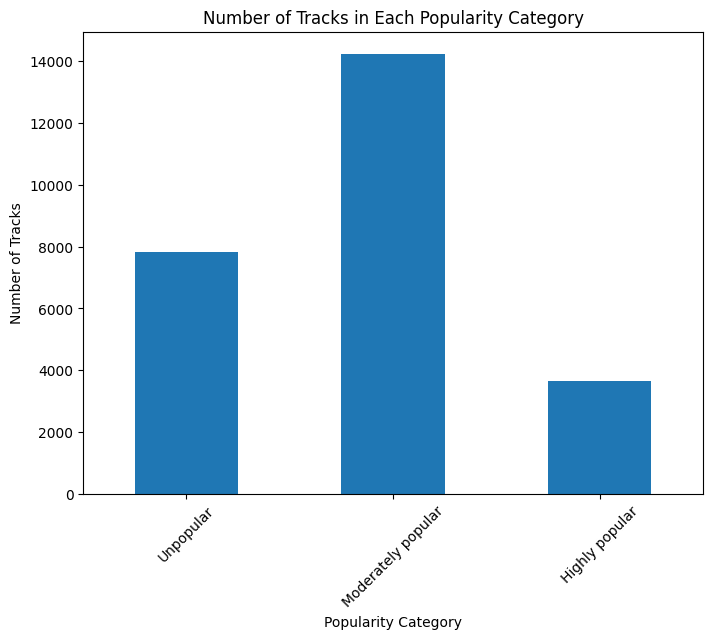

In [14]:
#Count and Visualize the bins
bin_counts = merged_df['popularity_bin'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 6))
bin_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Popularity Category')
plt.ylabel('Number of Tracks')
plt.title('Number of Tracks in Each Popularity Category')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

## EDA



### Info on Dataset

#### Displaying Data Overview
The dataset's structure and content were examined by displaying the first few rows. This step provided an initial understanding of the data, column names, and potential issues requiring cleaning.

#### Dataset Summary
The `.info()` method was used to summarize the dataset, detailing the data types and non-null counts for each column. This helped identify columns with missing values or inconsistent data types.

#### Statistical Summary
Descriptive statistics for numerical variables were generated using `.describe()`. These included metrics like mean, standard deviation, and range, providing insights into feature distributions and identifying potential outliers.


In [15]:
#Info on dataset

# Display the first few rows
# Temporarily set max columns to None to display all columns
pd.options.display.max_columns = None

print("")
print("--------- Head ---------:")
print(merged_df.head())

# Reset display option if desired
pd.reset_option('display.max_columns')

#Display info
print("")
print("--------- Info: ---------")
merged_df.info()

# Summary statistics for numerical variables
print("")
print("--------- Description: ---------")
print(merged_df.describe())


--------- Head ---------:
                                          track_name      track_artist  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...        ed sheeran   
1                    Memories - Dillon Francis Remix          maroon 5   
2                    All the Time - Don Diablo Remix      zara larsson   
3                  Call You Mine - Keanu Silva Remix  the chainsmokers   
4            Someone You Loved - Future Humans Remix     lewis capaldi   

   track_popularity                                   track_album_name  \
0                66  I Don't Care (with Justin Bieber) [Loud Luxury...   
1                67                    Memories (Dillon Francis Remix)   
2                70                    All the Time (Don Diablo Remix)   
3                60                        Call You Mine - The Remixes   
4                69            Someone You Loved (Future Humans Remix)   

  playlist_name playlist_genre playlist_subgenre  danceability  energy  key  \
0   

### Naive Rule

#### Definition
The naive rule was applied as a baseline by identifying the most frequent popularity bin in the dataset. This bin was then predicted for all tracks.

#### Accuracy Evaluation
The accuracy of the naive rule was calculated by comparing the most frequent bin predictions to actual bins. This established a benchmark for model performance.

#### Visualization
The distribution of the `track_popularity` feature was visualized using a histogram. This showed the spread of popularity scores and highlighted any skewness.

In [16]:
# Find the most frequent bin (mode) in merged_df
most_frequent_bin = merged_df['popularity_bin'].value_counts().idxmax()

# Add a naive prediction column based on the most frequent bin
merged_df['naive_prediction'] = most_frequent_bin

# Calculate the accuracy of the naive rule
naive_accuracy = (merged_df['popularity_bin'] == merged_df['naive_prediction']).mean()

# Print results
print(f"The most frequent bin is: {most_frequent_bin}")
print(f"Naive Rule Accuracy: {naive_accuracy:.2f}")
print("This is the accuracy we are trying to beat.")

# Drop the temporary column to avoid interference
merged_df.drop(columns=['naive_prediction'], inplace=True)

The most frequent bin is: Moderately popular
Naive Rule Accuracy: 0.55
This is the accuracy we are trying to beat.


### Popularity Analysis
Histograms were created to visualize the distributions of `artist_avg_popularity` and `track_popularity`. These plots helped identify trends and variations in artist and track popularity.

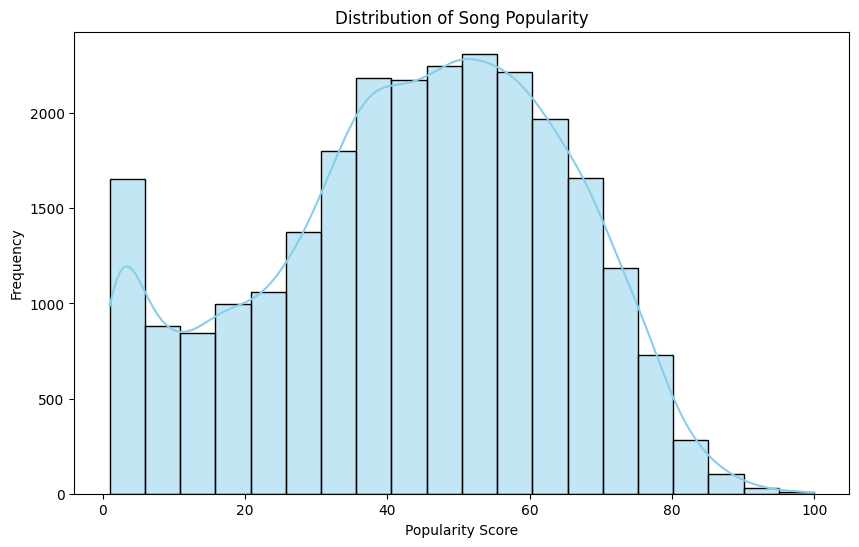

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['track_popularity'], kde=True, bins=20, color='skyblue')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')
plt.show()

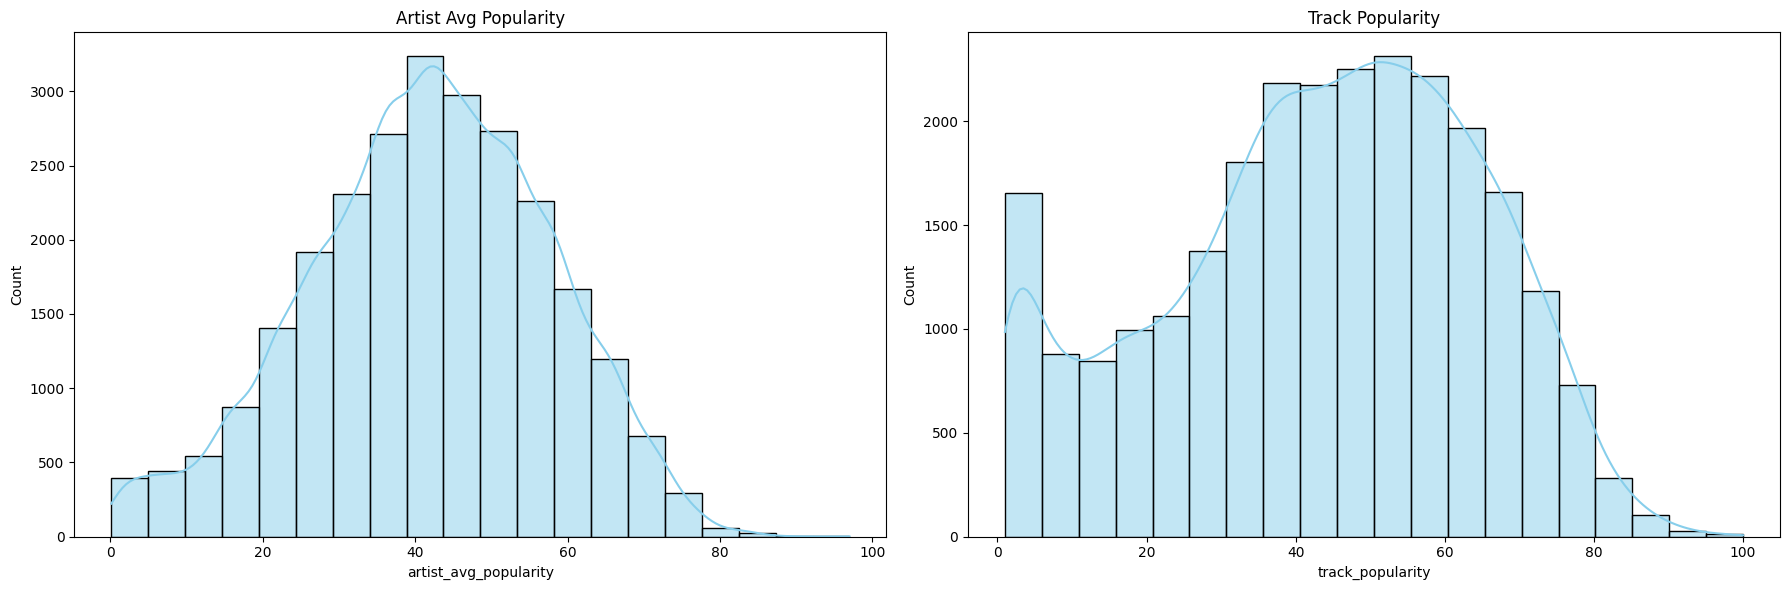

In [18]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)  # (rows, columns, index)
sns.histplot(merged_df['artist_avg_popularity'], kde=True, bins=20, color='skyblue')
plt.title('Artist Avg Popularity')

# Plot 3: Histogram for 'track_popularity'
plt.subplot(1, 2, 2)  # (rows, columns, index)
sns.histplot(merged_df['track_popularity'], kde=True, bins=20, color='skyblue')
plt.title('Track Popularity')

plt.tight_layout()
plt.show()

### Correlation Analysis
A correlation heatmap was generated for numerical features. This analysis identified relationships between features, which guided feature selection and engineering.

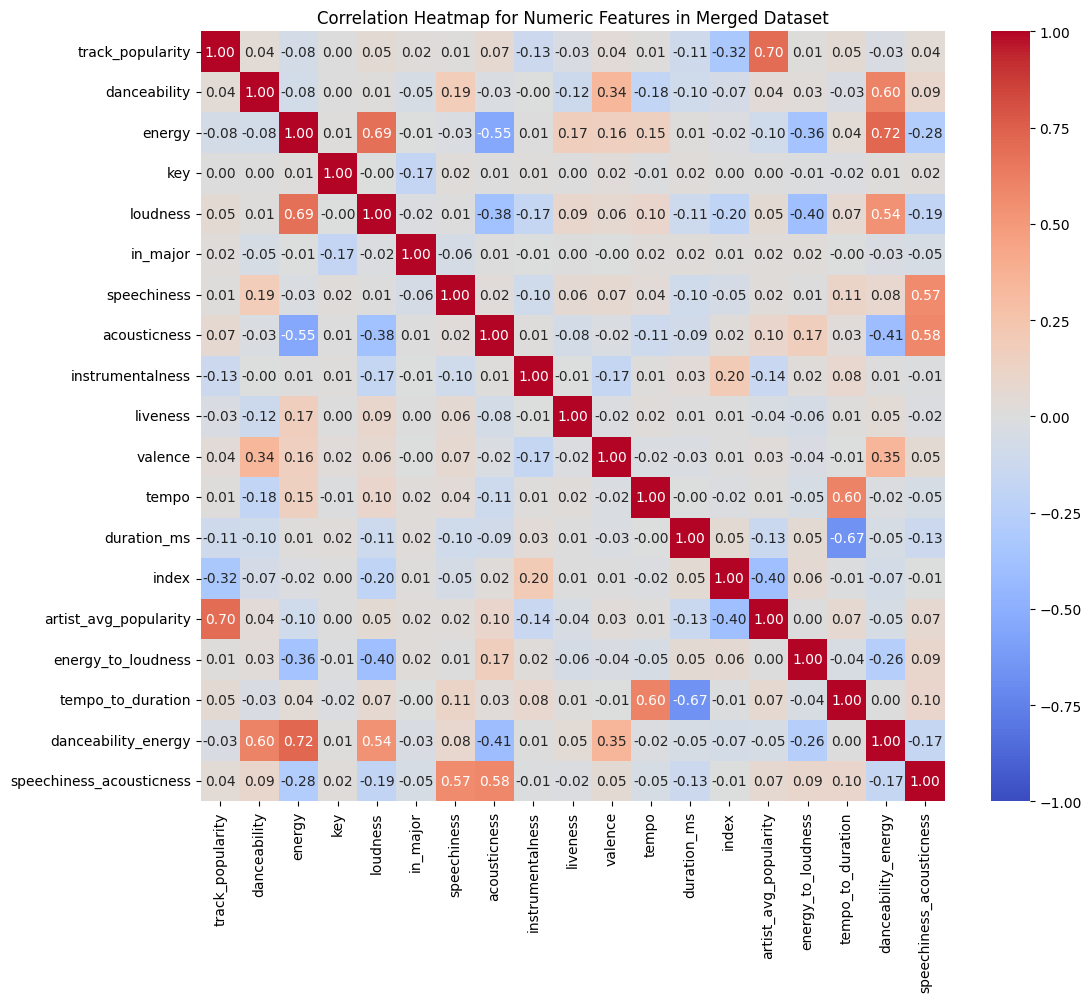

In [19]:
# Compute correlation matrix for numeric features in merged_df
numeric_merged_df = merged_df.select_dtypes(include=[np.number])  # Select only numeric columns
correlation_matrix = numeric_merged_df.corr()

# Plot heatmap for merged_df
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Numeric Features in Merged Dataset")
plt.show()

### Clustering
K-Means clustering was applied to group tracks based on energy, tempo, and danceability. A scatter plot visualized the resulting clusters, offering insights into song groupings.

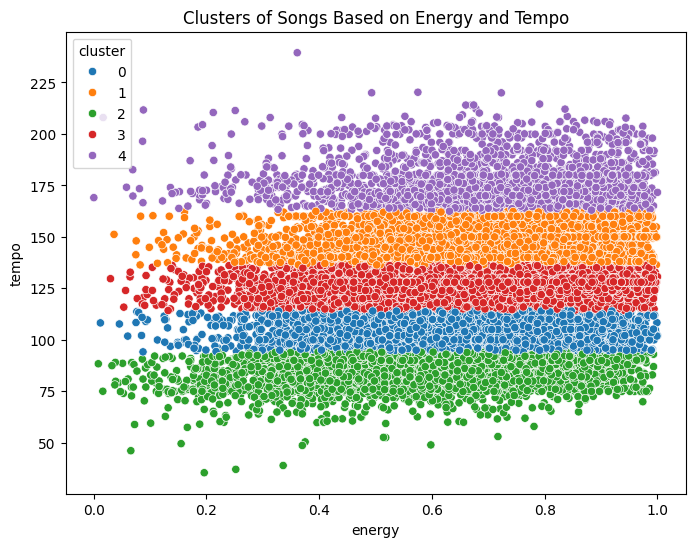

In [20]:
# Select relevant features for clustering
features = merged_df[['danceability', 'energy', 'tempo']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(features)
merged_df['cluster'] = kmeans.labels_

# Scatter plot with clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='energy', y='tempo', hue='cluster', palette='tab10')
plt.title('Clusters of Songs Based on Energy and Tempo')
plt.show()


### Release Trends by Decade
Average popularity scores were grouped by release decade to identify generational trends. The visualization reveals how listener preferences and platform exposure may vary over time, with more recent decades often scoring higher due to streaming-era accessibility.

<ipython-input-25-dae450dd6235>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='release_decade', y='track_popularity', data=df_decade, palette='coolwarm')


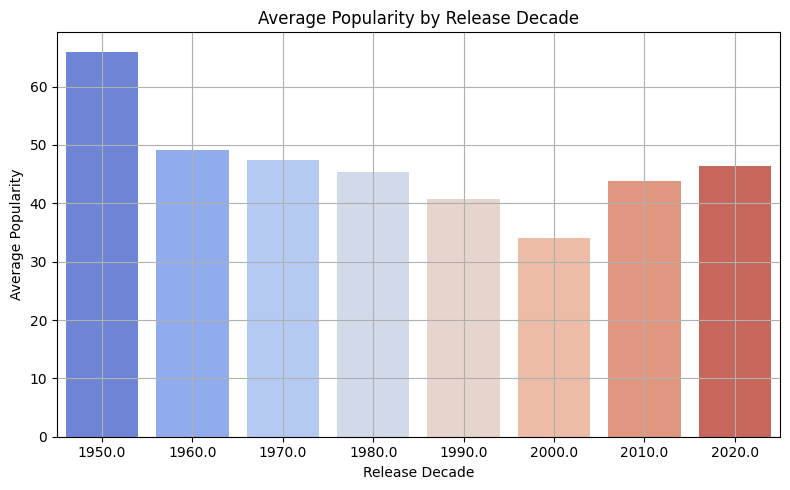

In [25]:
# Convert release date to datetime and extract year
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='coerce')
df['year'] = df['track_album_release_date'].dt.year

# Create decade column
df['release_decade'] = (df['year'] // 10) * 10

# Group by decade and calculate mean popularity
df_decade = df.groupby('release_decade', as_index=False)['track_popularity'].mean()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='release_decade', y='track_popularity', data=df_decade, palette='coolwarm')
plt.title("Average Popularity by Release Decade")
plt.xlabel("Release Decade")
plt.ylabel("Average Popularity")
plt.grid(True)
plt.tight_layout()
plt.show()

### Danceability vs. Popularity
A scatterplot of danceability versus popularity helps assess whether upbeat, rhythmically engaging tracks tend to perform better. The slight upward trend suggests that higher danceability may positively influence popularity, though the relationship is not strictly linear.

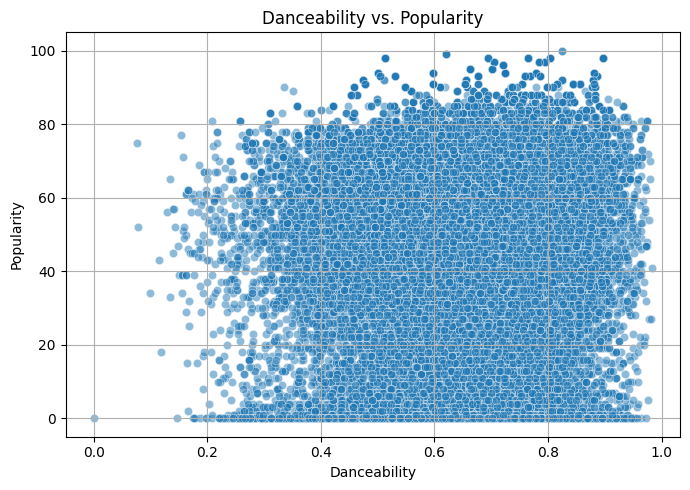

In [27]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x='danceability', y='track_popularity', data=df, alpha=0.5)
plt.title("Danceability vs. Popularity")
plt.xlabel("Danceability")
plt.ylabel("Popularity")
plt.grid(True)
plt.tight_layout()
plt.show()

## Data Transformation

### Encoding Categorical Variables
Categorical variables were encoded using `LabelEncoder`, transforming text-based columns into numerical representations suitable for machine learning models.

### Target Variable Encoding
The target variable, `popularity_bin`, was encoded numerically for classification tasks. This ensured compatibility with modeling frameworks.


In [28]:
# Encoding categorical variables
label_encoders = {}
for column in merged_df.select_dtypes(include='object').columns:
    label_encoders[column] = LabelEncoder()
    merged_df[column] = label_encoders[column].fit_transform(merged_df[column])

# Encode the target variable 'popularity_bin' and store it in label_encoders
label_encoders['popularity_bin'] = LabelEncoder()
y = label_encoders['popularity_bin'].fit_transform(merged_df['popularity_bin'])


# Prepare feature matrix
X = merged_df.drop(columns=['track_popularity', 'popularity_bin'])

### Skewness and Distribution Analysis

#### Feature Distribution
Histograms and QQ plots were used to analyze the distributions of key features. This step identified skewness and deviations from normality, which could affect model performance.

#### Transformation for Skewness
Logarithmic and square root transformations were applied to highly skewed features to reduce skewness and normalize distributions.

#### Skewness Comparison
A table comparing skewness before and after transformation was created, demonstrating the effectiveness of normalization techniques.


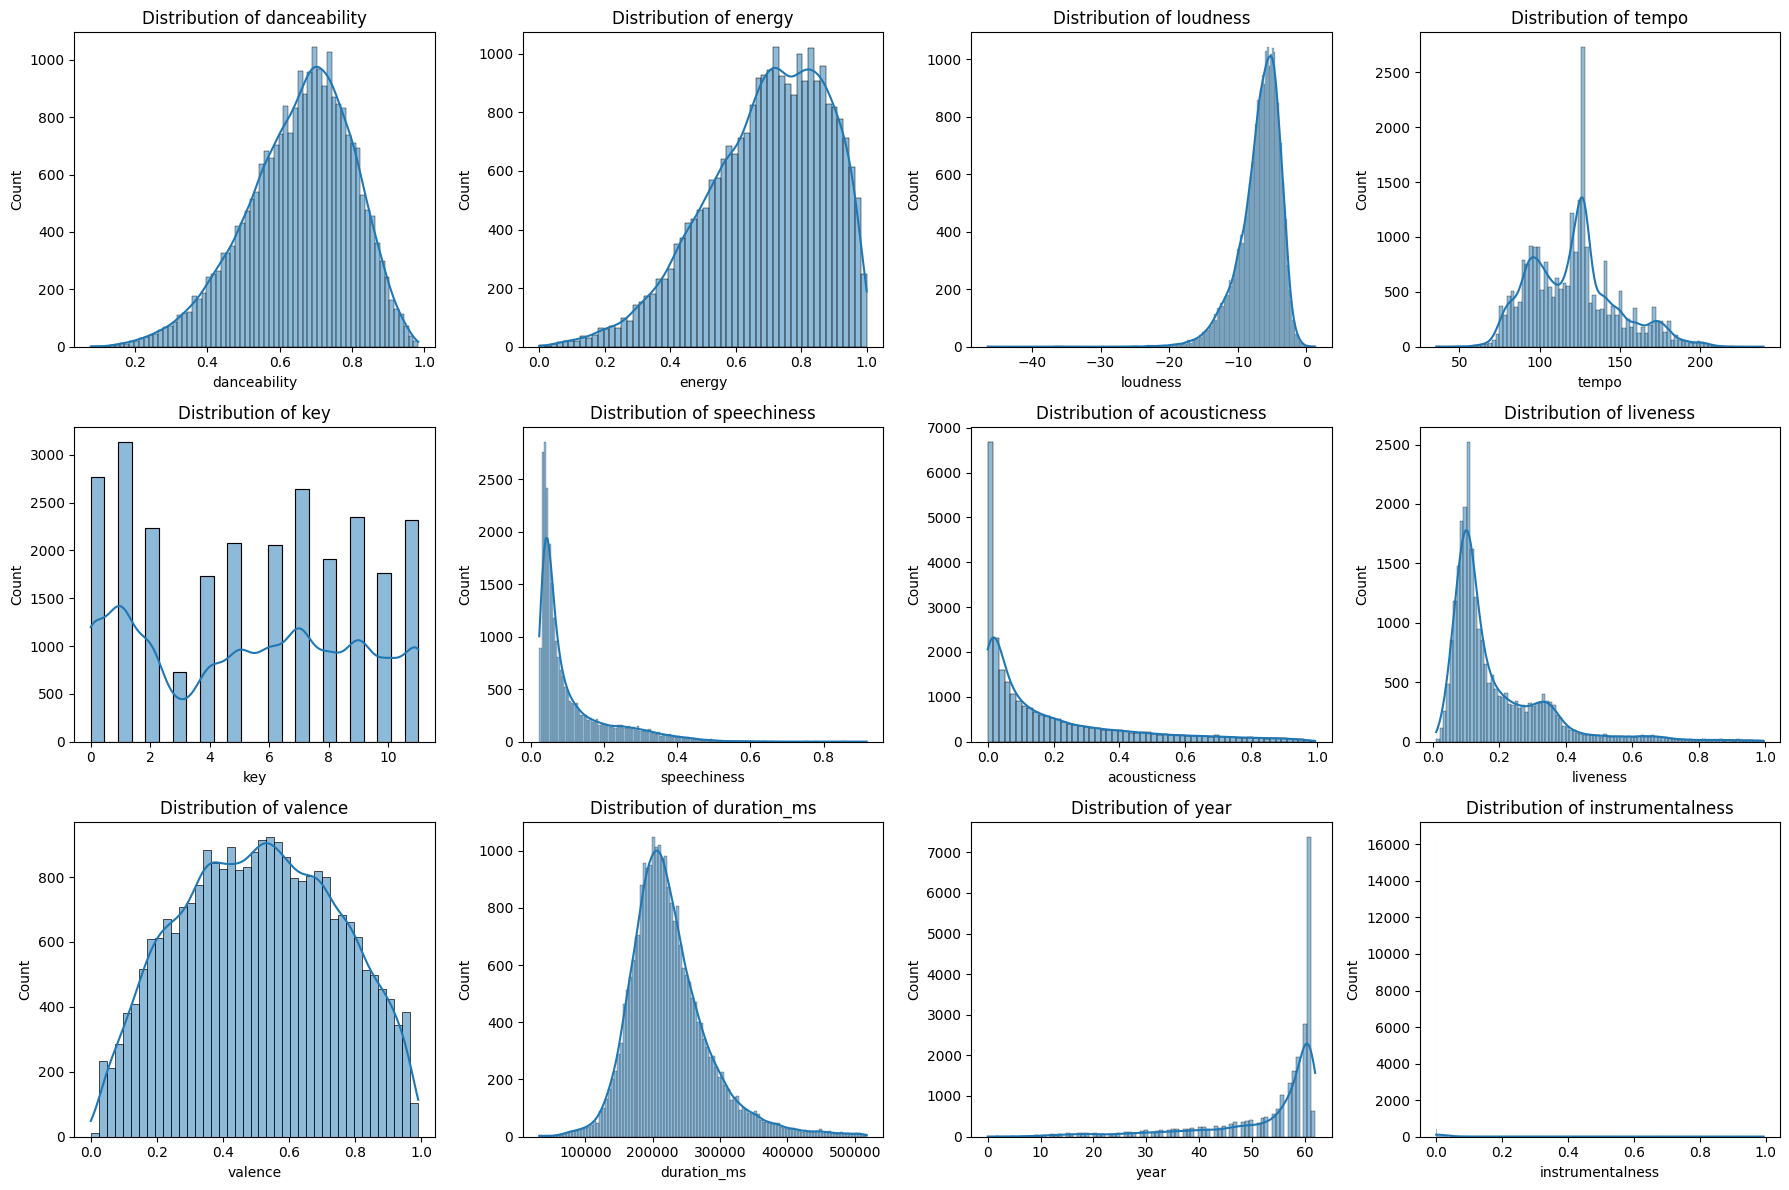

In [29]:
features = ['danceability', 'energy','loudness', 'tempo', 'key',
            'speechiness', 'acousticness', 'liveness', 'valence','duration_ms','year','instrumentalness']

# Update the grid size to accommodate all features
plt.figure(figsize=(18, 12))  # Adjust figure size for better visualization
for i, feature in enumerate(features, 1):
    plt.subplot(3, 4, i)  # Use a 3x4 grid for 10 features
    sns.histplot(merged_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


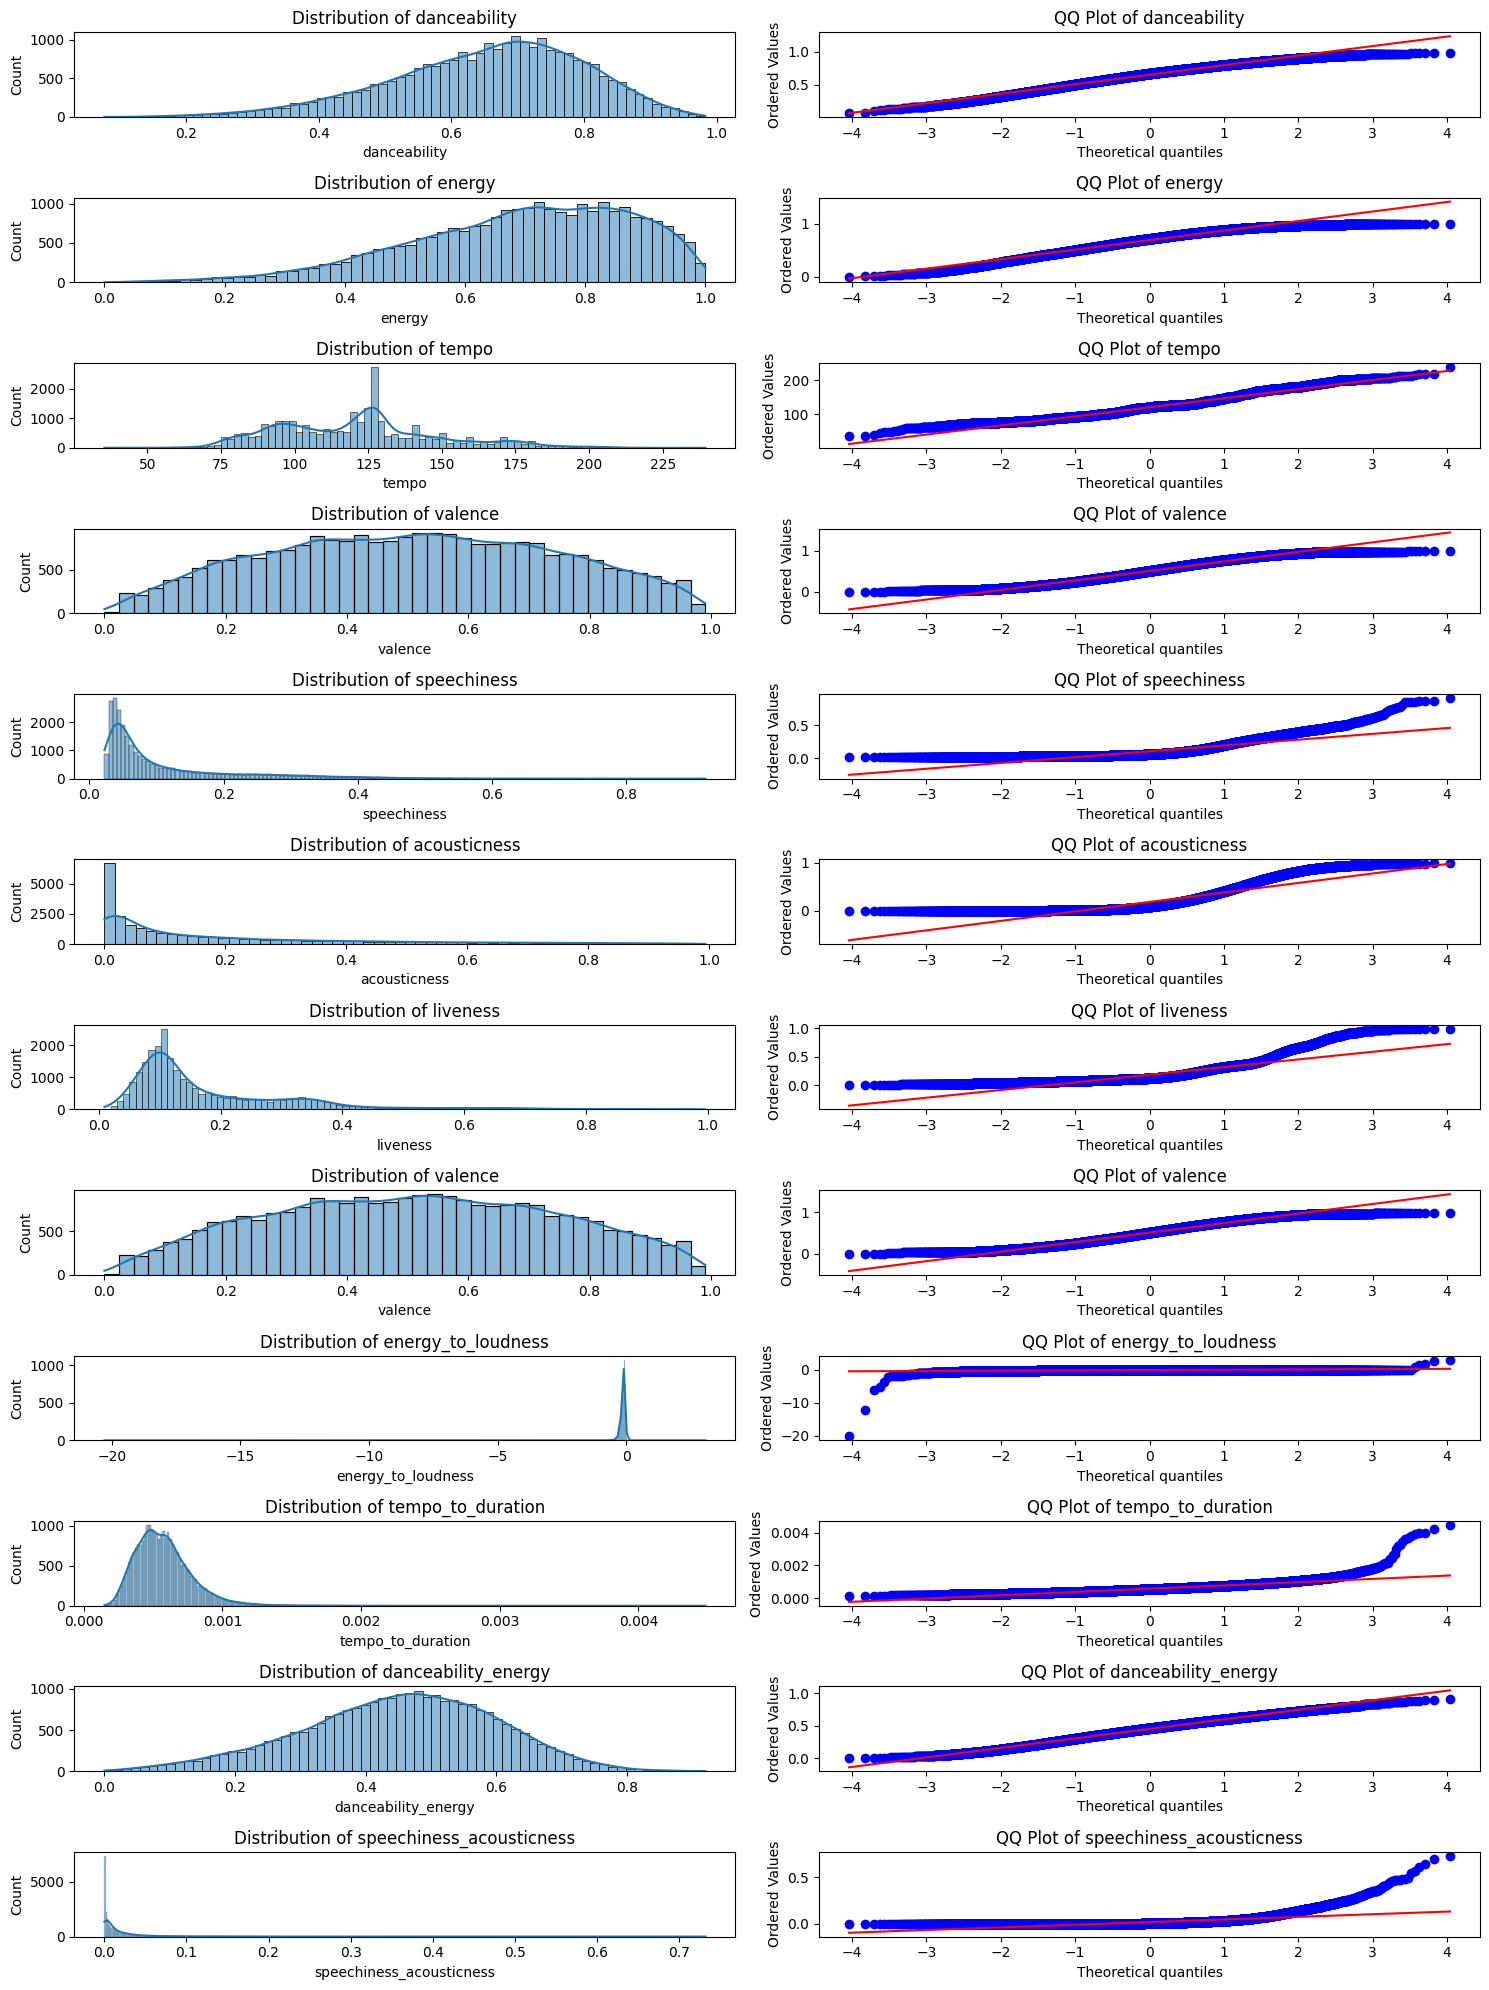

In [30]:
features = ['danceability', 'energy', 'tempo', 'valence', 'speechiness', 'acousticness', 'liveness', 'valence', 'energy_to_loudness',
            'tempo_to_duration','danceability_energy','speechiness_acousticness']

plt.figure(figsize=(15, 20))
for i, feature in enumerate(features, 1):
    #Histrogram
    plt.subplot(len(features), 2, i * 2 - 1)
    sns.histplot(merged_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')

    # QQ plot
    plt.subplot(len(features), 2, i * 2)
    stats.probplot(merged_df[feature], dist="norm", plot=plt)
    plt.title(f'QQ Plot of {feature}')

plt.tight_layout()
plt.show()

In [31]:
# Calculate skewness for each feature
for feature in features:
    skewness = merged_df[feature].skew()
    print(f"Skewness of {feature}: {skewness}")

Skewness of danceability: -0.506068059489781
Skewness of energy: -0.6294588951260597
Skewness of tempo: 0.5208978071429146
Skewness of valence: 0.0011669920831028375
Skewness of speechiness: 1.970788620103434
Skewness of acousticness: 1.5356906754606208
Skewness of liveness: 2.0937288622816754
Skewness of valence: 0.0011669920831028375
Skewness of energy_to_loudness: -61.053913252725515
Skewness of tempo_to_duration: 2.693950100163092
Skewness of danceability_energy: -0.24630421242509365
Skewness of speechiness_acousticness: 4.859497389160454


In [32]:
# Apply log transformation to skewed features (with skewness > 1 or < -1)
merged_df['log_loudness'] = np.log1p(merged_df['loudness'])
merged_df['log_speechiness'] = np.log1p(merged_df['speechiness'])  # log1p handles zero values
merged_df['log_acousticness'] = np.log1p(merged_df['acousticness'])
merged_df['log_instrumentalness'] = np.log1p(merged_df['instrumentalness'])
merged_df['log_liveness'] = np.log1p(merged_df['liveness'])
merged_df['log_duration_ms'] = np.log1p(merged_df['duration_ms'])
merged_df['log_year'] = np.log1p(merged_df['year'])
merged_df['log_tempo_to_duration'] = np.log1p(merged_df['tempo_to_duration'])
merged_df['log_speechiness_acousticness'] = np.log1p(merged_df['speechiness_acousticness'])
merged_df['log_energy_to_loudness'] = np.log1p(merged_df['energy_to_loudness'])

# Check skewness after log transformation
print(merged_df[['log_loudness','log_speechiness', 'log_acousticness', 'log_instrumentalness', 'log_liveness','log_duration_ms',
                 'log_year','log_tempo_to_duration', 'log_speechiness_acousticness', 'log_energy_to_loudness',]].skew())

log_loudness                   -0.718129
log_speechiness                 1.715874
log_acousticness                1.246327
log_instrumentalness            2.547495
log_liveness                    1.680290
log_duration_ms                -0.203352
log_year                       -3.022656
log_tempo_to_duration           2.686866
log_speechiness_acousticness    4.178523
log_energy_to_loudness         -8.189300
dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
# Apply square root transformation to skewed features (with skewness > 1 or < -1)
merged_df['sqrt_loudness'] = np.sqrt(merged_df['loudness'])
merged_df['sqrt_speechiness'] = np.sqrt(merged_df['speechiness'])
merged_df['sqrt_acousticness'] = np.sqrt(merged_df['acousticness'])
merged_df['sqrt_instrumentalness'] = np.sqrt(merged_df['instrumentalness'])
merged_df['sqrt_liveness'] = np.sqrt(merged_df['liveness'])
merged_df['sqrt_duration_ms'] = np.sqrt(merged_df['duration_ms'])
merged_df['sqrt_year'] = np.sqrt(merged_df['year'])
merged_df['sqrt_tempo_to_duration'] = np.sqrt(merged_df['tempo_to_duration'])
merged_df['sqrt_speechiness_acousticness'] = np.sqrt(merged_df['speechiness_acousticness'])
merged_df['sqrt_energy_to_loudness'] = np.sqrt(merged_df['energy_to_loudness'])

# Check skewness after square root transformation
print(merged_df[['sqrt_loudness','sqrt_speechiness', 'sqrt_acousticness', 'sqrt_instrumentalness', 'sqrt_liveness', 'sqrt_duration_ms', 'year',
                 'sqrt_tempo_to_duration', 'sqrt_speechiness_acousticness', 'sqrt_energy_to_loudness']].skew())

sqrt_loudness                    1.149838
sqrt_speechiness                 1.246499
sqrt_acousticness                0.634812
sqrt_instrumentalness            2.159325
sqrt_liveness                    1.206266
sqrt_duration_ms                 0.524499
year                            -1.859673
sqrt_tempo_to_duration           0.887141
sqrt_speechiness_acousticness    1.687022
sqrt_energy_to_loudness         -0.119049
dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [34]:
# Apply log transformation (handle zero and negative values by adding 1)
merged_df['log_loudness'] = np.log1p(merged_df['loudness'])
merged_df['log_speechiness'] = np.log1p(merged_df['speechiness'])  # log1p handles zero values
merged_df['log_acousticness'] = np.log1p(merged_df['acousticness'])
merged_df['log_instrumentalness'] = np.log1p(merged_df['instrumentalness'])
merged_df['log_liveness'] = np.log1p(merged_df['liveness'])
merged_df['log_duration_ms'] = np.log1p(merged_df['duration_ms'])
merged_df['log_year'] = np.log1p(merged_df['year'])
merged_df['log_tempo_to_duration'] = np.log1p(merged_df['tempo_to_duration'])
merged_df['log_speechiness_acousticness'] = np.log1p(merged_df['speechiness_acousticness'])
merged_df['log_energy_to_loudness'] = np.log1p(merged_df['energy_to_loudness'])

# Apply sqrt transformation (handle zero values by adding a small constant)
merged_df['sqrt_loudness'] = np.sqrt(merged_df['loudness'])
merged_df['sqrt_speechiness'] = np.sqrt(merged_df['speechiness'])
merged_df['sqrt_acousticness'] = np.sqrt(merged_df['acousticness'])
merged_df['sqrt_instrumentalness'] = np.sqrt(merged_df['instrumentalness'])
merged_df['sqrt_liveness'] = np.sqrt(merged_df['liveness'])
merged_df['sqrt_duration_ms'] = np.sqrt(merged_df['duration_ms'])
merged_df['sqrt_year'] = np.sqrt(merged_df['year'])
merged_df['sqrt_tempo_to_duration'] = np.sqrt(merged_df['tempo_to_duration'])
merged_df['sqrt_speechiness_acousticness'] = np.sqrt(merged_df['speechiness_acousticness'])
merged_df['sqrt_energy_to_loudness'] = np.sqrt(merged_df['energy_to_loudness'])


# Calculate skewness before and after transformation
comparison = pd.DataFrame({
    'Feature': ['loudness','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms', 'year',
                 'tempo_to_duration', 'speechiness_acousticness', 'energy_to_loudness'],
    'Skewness (Original)': [
        merged_df['loudness'].skew(),
        merged_df['speechiness'].skew(),
        merged_df['acousticness'].skew(),
        merged_df['instrumentalness'].skew(),
        merged_df['liveness'].skew(),
        merged_df['duration_ms'].skew(),
        merged_df['year'].skew(),
        merged_df['tempo_to_duration'].skew(),
        merged_df['speechiness_acousticness'].skew(),
        merged_df['energy_to_loudness'].skew()

    ],
    'Skewness (Log)': [
        merged_df['log_loudness'].skew(),
        merged_df['log_speechiness'].skew(),
        merged_df['log_acousticness'].skew(),
        merged_df['log_instrumentalness'].skew(),
        merged_df['log_liveness'].skew(),
        merged_df['log_duration_ms'].skew(),
        merged_df['log_year'].skew(),
        merged_df['log_tempo_to_duration'].skew(),
        merged_df['log_speechiness_acousticness'].skew(),
        merged_df['log_energy_to_loudness'].skew()
    ],
    'Skewness (Sqrt)': [
        merged_df['sqrt_loudness'].skew(),
        merged_df['sqrt_speechiness'].skew(),
        merged_df['sqrt_acousticness'].skew(),
        merged_df['sqrt_instrumentalness'].skew(),
        merged_df['sqrt_liveness'].skew(),
        merged_df['sqrt_duration_ms'].skew(),
        merged_df['sqrt_year'].skew(),
        merged_df['sqrt_tempo_to_duration'].skew(),
        merged_df['sqrt_speechiness_acousticness'].skew(),
        merged_df['sqrt_energy_to_loudness'].skew()
    ]
})

# Display the comparison table
print(merged_df.columns)
comparison

Index(['track_name', 'track_artist', 'track_popularity', 'track_album_name',
       'playlist_name', 'playlist_genre', 'playlist_subgenre', 'danceability',
       'energy', 'key', 'loudness', 'in_major', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'index', 'year', 'artist_avg_popularity', 'energy_to_loudness',
       'tempo_to_duration', 'danceability_energy', 'speechiness_acousticness',
       'popularity_bin', 'cluster', 'log_loudness', 'log_speechiness',
       'log_acousticness', 'log_instrumentalness', 'log_liveness',
       'log_duration_ms', 'log_year', 'log_tempo_to_duration',
       'log_speechiness_acousticness', 'log_energy_to_loudness',
       'sqrt_loudness', 'sqrt_speechiness', 'sqrt_acousticness',
       'sqrt_instrumentalness', 'sqrt_liveness', 'sqrt_duration_ms',
       'sqrt_year', 'sqrt_tempo_to_duration', 'sqrt_speechiness_acousticness',
       'sqrt_energy_to_loudness'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Feature  Skewness (Original)  Skewness (Log)  \
0                  loudness            -1.375241       -0.718129   
1               speechiness             1.970789        1.715874   
2              acousticness             1.535691        1.246327   
3          instrumentalness             2.693541        2.547495   
4                  liveness             2.093729        1.680290   
5               duration_ms             1.142565       -0.203352   
6                      year            -1.859673       -3.022656   
7         tempo_to_duration             2.693950        2.686866   
8  speechiness_acousticness             4.859497        4.178523   
9        energy_to_loudness           -61.053913       -8.189300   

   Skewness (Sqrt)  
0         1.149838  
1         1.246499  
2         0.634812  
3         2.159325  
4         1.206266  
5         0.524499  
6        -2.293226  
7         0.887141  
8         1.687022  
9        -0.119049

In [35]:
merged_df = merged_df.drop(columns=['loudness','log_loudness','speechiness','log_speechiness','acousticness','log_acousticness', 'instrumentalness','log_instrumentalness',
                                    'log_liveness','liveness', 'duration_ms','sqrt_duration_ms','log_year','sqrt_year','tempo_to_duration', 'log_tempo_to_duration',
                                    'speechiness_acousticness','log_speechiness_acousticness','energy_to_loudness','log_energy_to_loudness'])

print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 25721 entries, 0 to 28318
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   track_name                     25721 non-null  int64   
 1   track_artist                   25721 non-null  int64   
 2   track_popularity               25721 non-null  int64   
 3   track_album_name               25721 non-null  int64   
 4   playlist_name                  25721 non-null  int64   
 5   playlist_genre                 25721 non-null  int64   
 6   playlist_subgenre              25721 non-null  int64   
 7   danceability                   25721 non-null  float64 
 8   energy                         25721 non-null  float64 
 9   key                            25721 non-null  int64   
 10  in_major                       25721 non-null  int64   
 11  valence                        25721 non-null  float64 
 12  tempo                          25721 

### Scailing Numerical Features

A `MinMaxScaler` was applied to scale numerical features, standardizing them to a range of 0 to 1. This ensured features were comparable and improved model performance.


In [36]:
scaler = MinMaxScaler()
numeric_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

## Modeling


### Modeling Preparation: Target, Features, and Train-Test Split

In [37]:
print(merged_df.isna().sum())

track_name                           0
track_artist                         0
track_popularity                     0
track_album_name                     0
playlist_name                        0
playlist_genre                       0
playlist_subgenre                    0
danceability                         0
energy                               0
key                                  0
in_major                             0
valence                              0
tempo                                0
index                                0
year                                 0
artist_avg_popularity                0
danceability_energy                  0
popularity_bin                       0
cluster                              0
log_duration_ms                      0
sqrt_loudness                    25716
sqrt_speechiness                     0
sqrt_acousticness                    0
sqrt_instrumentalness                0
sqrt_liveness                        0
sqrt_tempo_to_duration   

In [38]:
# Ensure 'popularity_bin' is encoded and target variable is defined
label_encoders['popularity_bin'] = LabelEncoder()
y = label_encoders['popularity_bin'].fit_transform(merged_df['popularity_bin'])

# Prepare the feature matrix
X = merged_df.drop(columns=['track_popularity', 'popularity_bin'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the split
print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (20576, 26), Testing set size: (5145, 26)


In [39]:
print(X_train.isna().sum())

track_name                           0
track_artist                         0
track_album_name                     0
playlist_name                        0
playlist_genre                       0
playlist_subgenre                    0
danceability                         0
energy                               0
key                                  0
in_major                             0
valence                              0
tempo                                0
index                                0
year                                 0
artist_avg_popularity                0
danceability_energy                  0
cluster                              0
log_duration_ms                      0
sqrt_loudness                    20572
sqrt_speechiness                     0
sqrt_acousticness                    0
sqrt_instrumentalness                0
sqrt_liveness                        0
sqrt_tempo_to_duration               0
sqrt_speechiness_acousticness        0
sqrt_energy_to_loudness  

In [40]:
# Check for missing values
print(f"Missing values in X_train: {np.isnan(X_train).sum().sum()}")
print(f"Missing values in y_train: {np.isnan(y_train).sum()}")

Missing values in X_train: 41144
Missing values in y_train: 0


In [41]:
missing_columns = X_train.columns[X_train.isna().any()]
print(f"Columns with missing values: {missing_columns}")

Columns with missing values: Index(['sqrt_loudness', 'sqrt_energy_to_loudness'], dtype='object')


In [42]:
# Drop columns with missing values
X_train.drop(columns=['sqrt_loudness', 'sqrt_energy_to_loudness'], inplace=True)
X_test.drop(columns=['sqrt_loudness', 'sqrt_energy_to_loudness'], inplace=True)

In [43]:
# Check for missing values
print(f"Missing values in X_train: {np.isnan(X_train).sum().sum()}")
print(f"Missing values in y_train: {np.isnan(y_train).sum()}")

Missing values in X_train: 0
Missing values in y_train: 0


### Boosting and Bagging

#### How to Use the Code
- **Bagging**: Combines predictions from multiple base estimators trained on random subsets of the data.
- **Boosting**: Sequentially trains models, giving more weight to samples misclassified in previous iterations.

#### Examples
- `bagging_model`: Implements bagging with a chosen base estimator.
- `adaboost_model`: Implements boosting using AdaBoost.
- `gradient_boosting`: Implements gradient boosting with customizable parameters.
- `xgboost_model`: Implements XGBoost for further flexibility.


In [44]:
def bagging_model(estimator, X_train, X_test, y_train, y_test, problem_type="classification", n_estimators=100, max_samples=0.8, max_features=0.8):
    """
    Train and evaluate a Bagging model (Classifier or Regressor).
    """
    if problem_type == "classification":
        model = BaggingClassifier(
            estimator=estimator,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            random_state=42
        )
    else:
        model = BaggingRegressor(
            estimator=estimator,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
            random_state=42
        )

    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Bagging - Training Accuracy/Score: {round(train_score * 100, 2)}%")
    print(f"Bagging - Testing Accuracy/Score: {round(test_score * 100, 2)}%")
    return model


def adaboost_model(estimator, X_train, X_test, y_train, y_test, problem_type="classification", n_estimators=100, learning_rate=0.1):
    """
    Train and evaluate an AdaBoost model (Classifier or Regressor).
    """
    if problem_type == "classification":
        model = AdaBoostClassifier(
            estimator=estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )
    else:
        model = AdaBoostRegressor(
            estimator=estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=42
        )

    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"AdaBoost - Training Accuracy/Score: {round(train_score * 100, 2)}%")
    print(f"AdaBoost - Testing Accuracy/Score: {round(test_score * 100, 2)}%")
    return model


def gradient_boosting(X_train, X_test, y_train, y_test, problem_type="classification", n_estimators=100, learning_rate=0.1, max_depth=3):
    """
    Train and evaluate a Gradient Boosting model (Classifier or Regressor).
    """
    if problem_type == "classification":
        model = GradientBoostingClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )
    else:
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )

    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"Gradient Boosting - Training Accuracy/Score: {round(train_score * 100, 2)}%")
    print(f"Gradient Boosting - Testing Accuracy/Score: {round(test_score * 100, 2)}%")
    return model


def xgboost_model(X_train, X_test, y_train, y_test, problem_type="classification", n_estimators=100, learning_rate=0.1, max_depth=3):
    """
    Train and evaluate an XGBoost model (Classifier or Regressor).
    """
    if problem_type == "classification":
        model = XGBClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42,
            use_label_encoder=False,
            eval_metric="mlogloss"
        )
    else:
        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=42
        )

    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f"XGBoost - Training Accuracy/Score: {round(train_score * 100, 2)}%")
    print(f"XGBoost - Testing Accuracy/Score: {round(test_score * 100, 2)}%")
    return model

### 1. Linear Regression

Linear regression was used as a baseline model to predict song popularity.

#### Steps
1. **Baseline Model**:
   - Trained on the full training set.
   - Evaluated using MSE, R-squared, and cross-validation scores.
   - Visualized actual vs. predicted popularity.

2. **With Bagging**:
   - Applied bagging with linear regression as the base estimator.
   - Improved robustness by averaging predictions over multiple estimators.

#### Baseline

Linear Regression - Training MSE: 0.25, R-squared: 0.41
Linear Regression - Testing MSE: 0.24, R-squared: 0.43
Linear Regression - Training Accuracy: 41.25%, Testing Accuracy: 43.17%
Cross-Validation R-squared Scores: [0.40450103 0.39876177 0.39641134 0.41962331 0.43617449]
Mean CV R-squared: 0.41, Std CV R-squared: 0.01


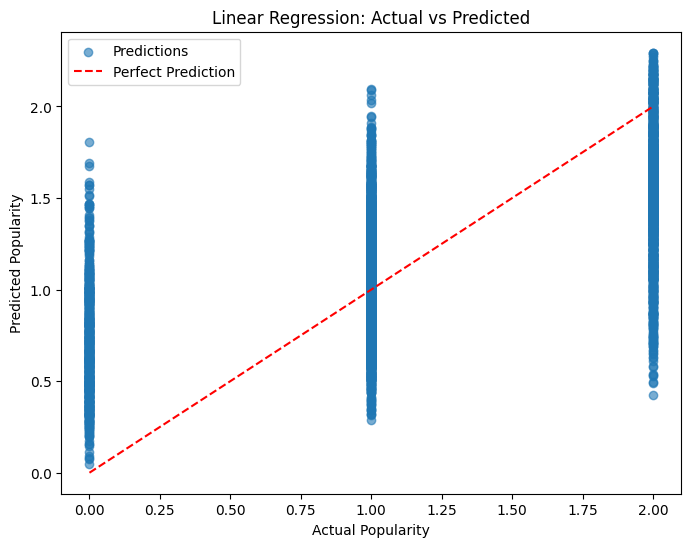

In [45]:
# Train Linear Regression (Baseline)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Linear Regression - Training MSE: {train_mse:.2f}, R-squared: {train_r2:.2f}")
print(f"Linear Regression - Testing MSE: {test_mse:.2f}, R-squared: {test_r2:.2f}")
print(f"Linear Regression - Training Accuracy: {train_r2 * 100:.2f}%, Testing Accuracy: {test_r2 * 100:.2f}%")

# Cross-Validation
cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean CV R-squared: {cv_scores.mean():.2f}, Std CV R-squared: {cv_scores.std():.2f}")

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

#### With Bagging

Bagging Linear Regression - Training MSE: 0.25, R-squared: 0.41
Bagging Linear Regression - Testing MSE: 0.24, R-squared: 0.43
Bagging Linear Regression - Training Accuracy: 41.25%, Testing Accuracy: 43.17%
Cross-Validation R-squared Scores: [0.40443701 0.39875594 0.39639659 0.41960837 0.43615083]
Mean CV R-squared: 0.41, Std CV R-squared: 0.01


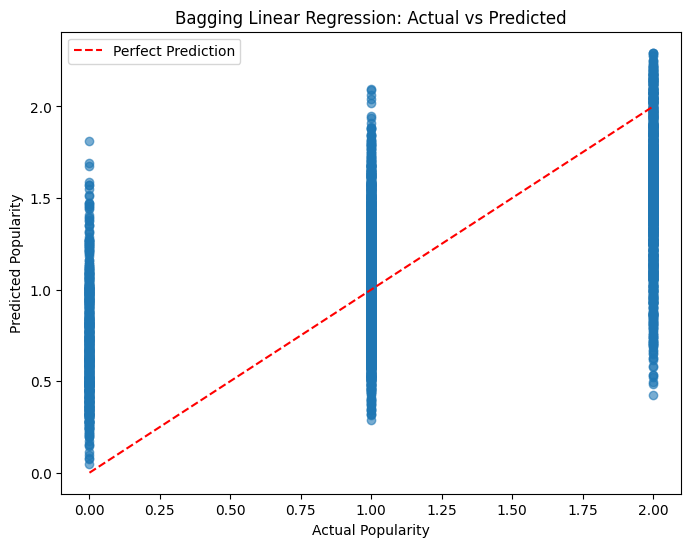

In [46]:
# Train Bagging with Linear Regression
bagging_model = BaggingRegressor(estimator=LinearRegression(), n_estimators=100, random_state=42)
bagging_model.fit(X_train, y_train)

# Predictions
y_train_pred = bagging_model.predict(X_train)
y_test_pred = bagging_model.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Bagging Linear Regression - Training MSE: {train_mse:.2f}, R-squared: {train_r2:.2f}")
print(f"Bagging Linear Regression - Testing MSE: {test_mse:.2f}, R-squared: {test_r2:.2f}")
print(f"Bagging Linear Regression - Training Accuracy: {train_r2 * 100:.2f}%, Testing Accuracy: {test_r2 * 100:.2f}%")

# Cross-Validation
cv_scores = cross_val_score(bagging_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean CV R-squared: {cv_scores.mean():.2f}, Std CV R-squared: {cv_scores.std():.2f}")

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Bagging Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

### 2. Ridge Regression

Ridge regression was applied to address multicollinearity by adding L2 regularization.

#### Steps
1. **Baseline Model**:
   - Evaluated MSE, R-squared, and cross-validation scores.
   - Plotted actual vs. predicted values.

2. **With Boosting**:
   - Used AdaBoost to enhance the performance of ridge regression by focusing on harder-to-predict samples.


#### Baseline

Cross-Validation R-squared Scores: [0.40489489 0.39872177 0.39623615 0.41935129 0.43643422]
Mean CV R-squared: 0.41, Std CV R-squared: 0.01
Ridge Regression - Training MSE: 0.25, R-squared: 0.41
Ridge Regression - Testing MSE: 0.24, R-squared: 0.43
Ridge Regression - Training Accuracy: 41.24%, Testing Accuracy: 43.17%


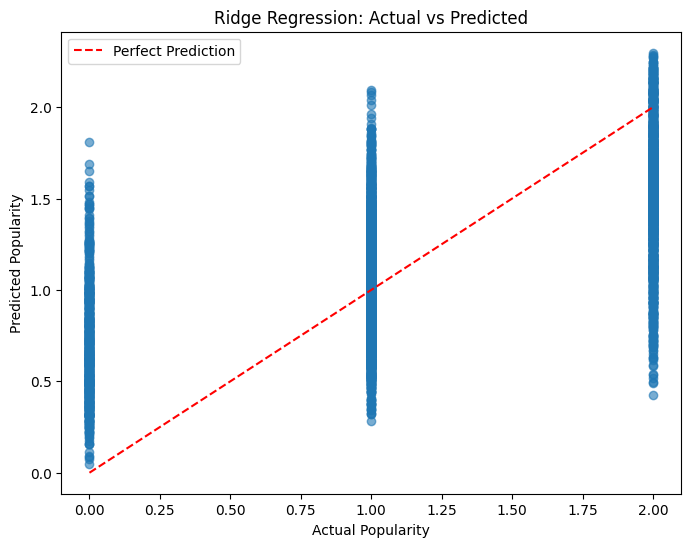

In [47]:
# Train Ridge Regression
ridge_model = Ridge(alpha=10)  # Use hyperparameter tuning here
ridge_model.fit(X_train, y_train)

# Cross-Validation
cv_scores = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean CV R-squared: {cv_scores.mean():.2f}, Std CV R-squared: {cv_scores.std():.2f}")

# Predictions
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Ridge Regression - Training MSE: {train_mse:.2f}, R-squared: {train_r2:.2f}")
print(f"Ridge Regression - Testing MSE: {test_mse:.2f}, R-squared: {test_r2:.2f}")
print(f"Ridge Regression - Training Accuracy: {train_r2 * 100:.2f}%, Testing Accuracy: {test_r2 * 100:.2f}%")

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Ridge Regression: Actual vs Predicted')
plt.legend()
plt.show()

#### With Boosting

AdaBoost Ridge Regression - Training MSE: 0.25, R-squared: 0.41
AdaBoost Ridge Regression - Testing MSE: 0.24, R-squared: 0.42
AdaBoost Ridge Regression - Training Accuracy: 40.86%, Testing Accuracy: 42.46%
Cross-Validation R-squared Scores: [0.40377612 0.39570479 0.39158202 0.41467079 0.42231857]
Mean CV R-squared: 0.41, Std CV R-squared: 0.01


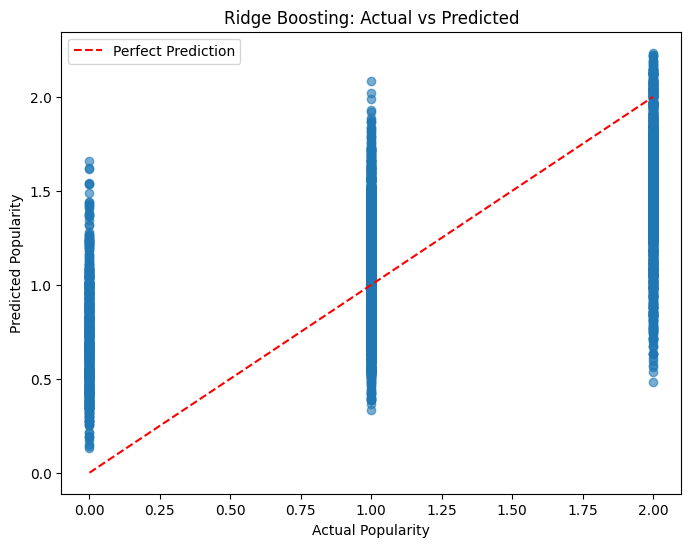

In [48]:
# Train AdaBoost with Ridge Regression
adaboost_ridge = AdaBoostRegressor(estimator=Ridge(alpha=10), n_estimators=100, random_state=42)
adaboost_ridge.fit(X_train, y_train)

# Predictions
y_train_pred = adaboost_ridge.predict(X_train)
y_test_pred = adaboost_ridge.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"AdaBoost Ridge Regression - Training MSE: {train_mse:.2f}, R-squared: {train_r2:.2f}")
print(f"AdaBoost Ridge Regression - Testing MSE: {test_mse:.2f}, R-squared: {test_r2:.2f}")
print(f"AdaBoost Ridge Regression - Training Accuracy: {train_r2 * 100:.2f}%, Testing Accuracy: {test_r2 * 100:.2f}%")

# Cross-Validation Evaluation
cv_scores = cross_val_score(adaboost_ridge, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean CV R-squared: {cv_scores.mean():.2f}, Std CV R-squared: {cv_scores.std():.2f}")

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Ridge Boosting: Actual vs Predicted')
plt.legend()
plt.show()

### 3. LASSO Regression

Lasso regression, incorporating L1 regularization, was used for feature selection and to handle sparsity.

#### Steps
1. **Baseline Model**:
   - Evaluated performance using MSE, R-squared, and cross-validation scores.
   - Visualized predictions.

2. **With Boosting**:
   - Enhanced lasso regression with AdaBoost to improve predictive accuracy.


#### Baseline

Lasso Regression - Training MSE: 0.25, R-squared: 0.41
Lasso Regression - Testing MSE: 0.24, R-squared: 0.43
Lasso Regression - Training Accuracy: 41.04%, Testing Accuracy: 43.11%
Cross-Validation R-squared Scores: [0.40338858 0.3965591  0.3969588  0.41903672 0.4332652 ]
Mean CV R-squared: 0.41, Std CV R-squared: 0.01


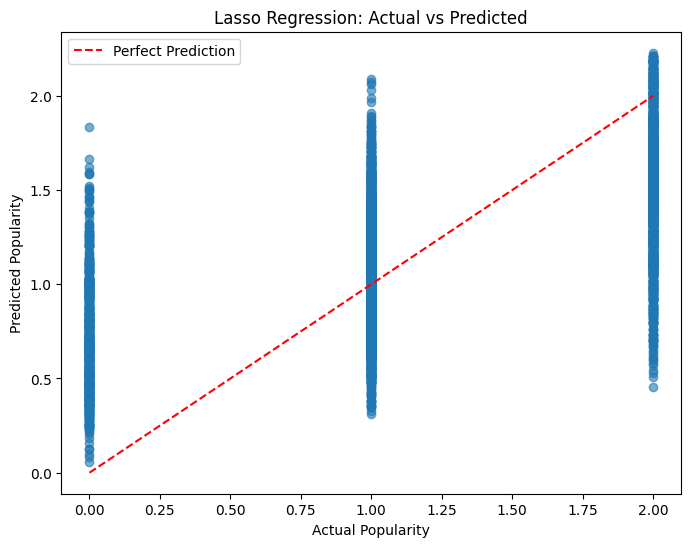

In [49]:
# Train Lasso Regression
lasso_model = Lasso(alpha=0.1)  # Use hyperparameter tuning here
lasso_model.fit(X_train, y_train)

# Predictions
y_train_pred = lasso_model.predict(X_train)
y_test_pred = lasso_model.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Lasso Regression - Training MSE: {train_mse:.2f}, R-squared: {train_r2:.2f}")
print(f"Lasso Regression - Testing MSE: {test_mse:.2f}, R-squared: {test_r2:.2f}")
print(f"Lasso Regression - Training Accuracy: {train_r2 * 100:.2f}%, Testing Accuracy: {test_r2 * 100:.2f}%")

# Cross-Validation Evaluation
cv_scores = cross_val_score(lasso_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean CV R-squared: {cv_scores.mean():.2f}, Std CV R-squared: {cv_scores.std():.2f}")

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Lasso Regression: Actual vs Predicted')
plt.legend()
plt.show()

#### With Boosting

Cross-Validation R-squared Scores: [0.40135435 0.39415935 0.38205326 0.41545296 0.42844265]
Mean CV R-squared: 0.40, Std CV R-squared: 0.02
Lasso Boosting - Training MSE: 0.25, R-squared: 0.40
Lasso Boosting - Testing MSE: 0.24, R-squared: 0.41
Lasso Boosting - Training Accuracy: 39.98%, Testing Accuracy: 41.47%


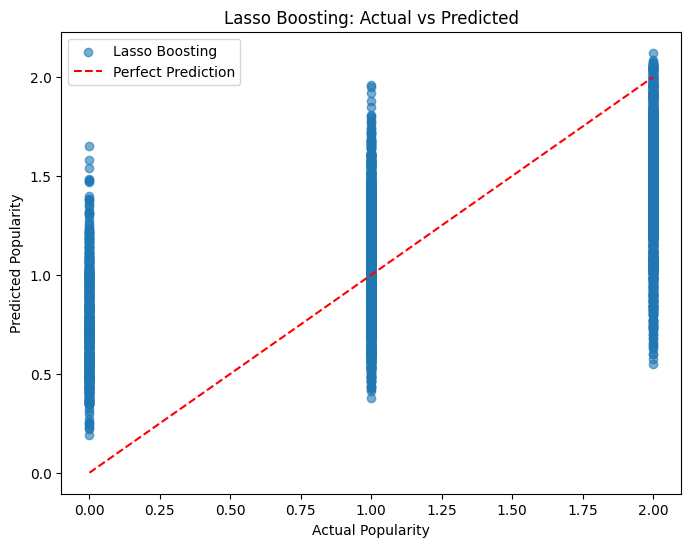

In [50]:
# Train Lasso Regression with Boosting using AdaBoost
lasso_model = Lasso(alpha=0.1)  # Lasso model (regularization strength)

# Using AdaBoost Regressor with Lasso as base estimator
ab_model = AdaBoostRegressor(estimator=lasso_model, n_estimators=100, random_state=42)

# Cross-validation
cv_scores = cross_val_score(ab_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean CV R-squared: {cv_scores.mean():.2f}, Std CV R-squared: {cv_scores.std():.2f}")

# Fit the model to the entire training set after CV evaluation
ab_model.fit(X_train, y_train)

# Predictions
y_train_pred = ab_model.predict(X_train)
y_test_pred = ab_model.predict(X_test)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print Results
print(f"Lasso Boosting - Training MSE: {train_mse:.2f}, R-squared: {train_r2:.2f}")
print(f"Lasso Boosting - Testing MSE: {test_mse:.2f}, R-squared: {test_r2:.2f}")
print(f"Lasso Boosting - Training Accuracy: {train_r2 * 100:.2f}%, Testing Accuracy: {test_r2 * 100:.2f}%")

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Lasso Boosting')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.title('Lasso Boosting: Actual vs Predicted')
plt.legend()
plt.show()

### 4. K-Nearest Neighbors (KNN)

KNN was used for classification, predicting popularity based on proximity to neighbors in the feature space.

### Steps
1. **Baseline Model**:
   - Evaluated accuracy, MSE, and confusion matrices.
   - Tuned hyperparameters like `n_neighbors` and distance metrics using GridSearchCV.

2. **With Bagging**:
   - Improved KNN stability by averaging predictions over bagged KNN models.

#### Baseline

Cross-Validation Accuracy Scores: [0.50655977 0.48262454 0.50789793 0.49939247 0.48845687]
Mean CV Accuracy: 0.50, Std CV Accuracy: 0.01
KNN - Training Accuracy: 65.9 %
KNN - Testing Accuracy: 48.6 %
KNN - Training MSE: 0.45
KNN - Testing MSE: 0.63
Confusion Matrix on training data:
[[1610 1182  150]
 [ 868 9351 1178]
 [ 569 3069 2599]]
Confusion Matrix on testing data:
[[ 242  403   62]
 [ 398 1903  548]
 [ 145 1088  356]]


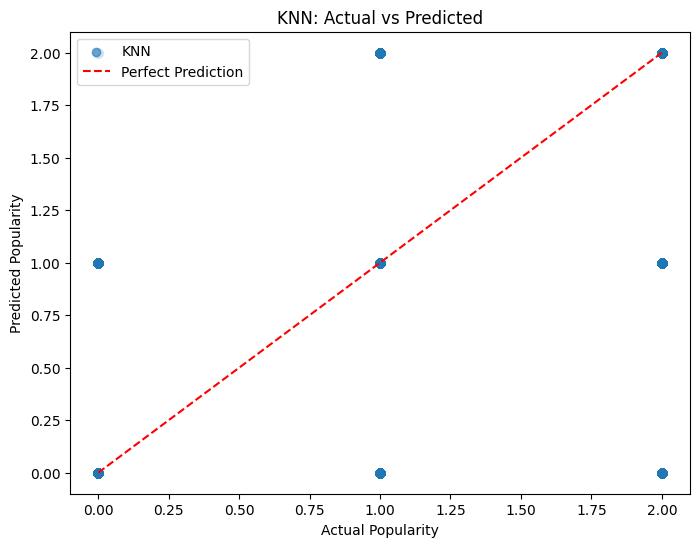

In [51]:
# Basic KNN Model
knn = KNeighborsClassifier()

# Cross-Validation
cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # Use 'accuracy' for classification
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.2f}, Std CV Accuracy: {cv_scores.std():.2f}")

# Train the model on the full training set
knn.fit(X_train, y_train)

# Predict and Evaluate
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

print('KNN - Training Accuracy:', round(train_accuracy * 100, 1), '%')
print('KNN - Testing Accuracy:', round(test_accuracy * 100, 1), '%')
print('KNN - Training MSE:', round(train_mse, 2))
print('KNN - Testing MSE:', round(test_mse, 2))

# Confusion Matrix
print("Confusion Matrix on training data:")
print(confusion_matrix(y_train, y_pred_train))
print("Confusion Matrix on testing data:")
print(confusion_matrix(y_test, y_pred_test))

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6, label='KNN')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.legend()
plt.title('KNN: Actual vs Predicted')
plt.show()

#### Hyperparameter Tuning

Best Parameters for KNN: {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
Best KNN - Training Accuracy: 59.4 %
Best KNN - Testing Accuracy: 54.1 %
Best KNN - Training MSE: 0.47
Best KNN - Testing MSE: 0.52
Confusion Matrix on training data (Bagging):
[[  857  1953   132]
 [  541 10131   725]
 [  299  4706  1232]]
Confusion Matrix on testing data (Bagging):
[[ 164  518   25]
 [ 202 2409  238]
 [  75 1301  213]]


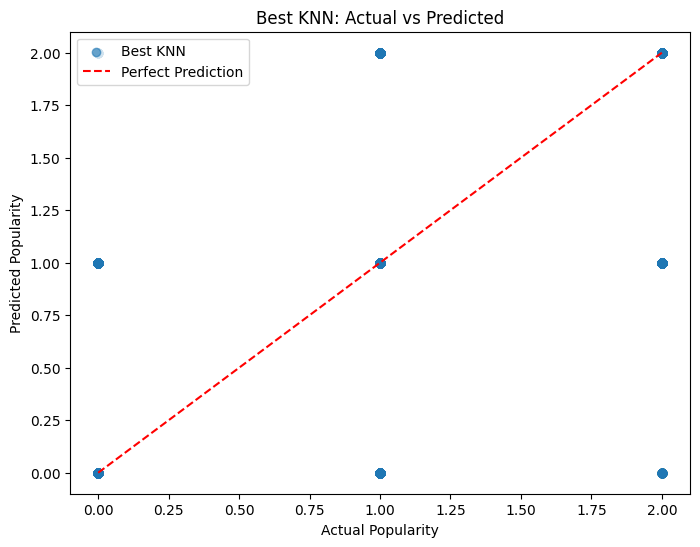

In [52]:
# Hyperparameter Tuning for KNN
param_grid = {
    'n_neighbors': [5, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 is Manhattan, p=2 is Euclidean
}
gridSearch = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
gridSearch.fit(X_train, y_train)

# Best Parameters
print("Best Parameters for KNN:", gridSearch.best_params_)

# Train Best KNN Model
best_knn = KNeighborsClassifier(
    n_neighbors=gridSearch.best_params_['n_neighbors'],
    weights=gridSearch.best_params_['weights'],
    p=gridSearch.best_params_['p']
)
best_knn.fit(X_train, y_train)

# Evaluate Best KNN
y_pred_train_best = best_knn.predict(X_train)
y_pred_test_best = best_knn.predict(X_test)

train_accuracy_best = accuracy_score(y_train, y_pred_train_best)
test_accuracy_best = accuracy_score(y_test, y_pred_test_best)
train_mse_best = mean_squared_error(y_train, y_pred_train_best)
test_mse_best = mean_squared_error(y_test, y_pred_test_best)

print('Best KNN - Training Accuracy:', round(train_accuracy_best * 100, 1), '%')
print('Best KNN - Testing Accuracy:', round(test_accuracy_best * 100, 1), '%')
print('Best KNN - Training MSE:', round(train_mse_best, 2))
print('Best KNN - Testing MSE:', round(test_mse_best, 2))

# Confusion Matrix
print("Confusion Matrix on training data (Bagging):")
print(confusion_matrix(y_train, y_pred_train_best))
print("Confusion Matrix on testing data (Bagging):")
print(confusion_matrix(y_test, y_pred_test_best))

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_best, alpha=0.6, label='Best KNN')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.legend()
plt.title('Best KNN: Actual vs Predicted')
plt.show()

#### With Bagging

Bagging KNN - Training Accuracy: 59.8 %
Bagging KNN - Testing Accuracy: 54.2 %
Bagging KNN - Training MSE: 0.46
Bagging KNN - Testing MSE: 0.51
Confusion Matrix on training data (Bagging):
[[  737  2056   149]
 [  417 10130   850]
 [  244  4548  1445]]
Confusion Matrix on testing data (Bagging):
[[ 137  539   31]
 [ 170 2392  287]
 [  63 1266  260]]


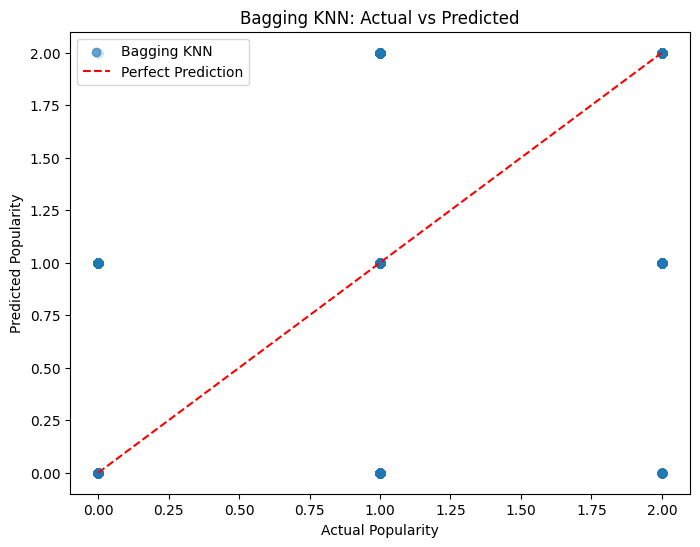

In [53]:
# Bagging KNN Model
bagging_knn = BaggingClassifier(estimator=best_knn, n_estimators=100, random_state=42)
bagging_knn.fit(X_train, y_train)

# Predict and Evaluate
y_pred_train_bagging = bagging_knn.predict(X_train)
y_pred_test_bagging = bagging_knn.predict(X_test)

train_accuracy_bagging = accuracy_score(y_train, y_pred_train_bagging)
test_accuracy_bagging = accuracy_score(y_test, y_pred_test_bagging)
train_mse_bagging = mean_squared_error(y_train, y_pred_train_bagging)
test_mse_bagging = mean_squared_error(y_test, y_pred_test_bagging)

print('Bagging KNN - Training Accuracy:', round(train_accuracy_bagging * 100, 1), '%')
print('Bagging KNN - Testing Accuracy:', round(test_accuracy_bagging * 100, 1), '%')
print('Bagging KNN - Training MSE:', round(train_mse_bagging, 2))
print('Bagging KNN - Testing MSE:', round(test_mse_bagging, 2))

# Confusion Matrix
print("Confusion Matrix on training data (Bagging):")
print(confusion_matrix(y_train, y_pred_train_bagging))
print("Confusion Matrix on testing data (Bagging):")
print(confusion_matrix(y_test, y_pred_test_bagging))

# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_bagging, alpha=0.6, label='Bagging KNN')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.legend()
plt.title('Bagging KNN: Actual vs Predicted')
plt.show()

### 5. Decision Tree

Decision trees were used to classify songs based on popularity, leveraging their interpretability and simplicity.

#### Steps
1. **Baseline Model**:
   - Trained on the full dataset and visualized the decision tree.
   - Evaluated accuracy and confusion matrices.

2. **Hyperparameter Tuning**:
   - Optimized tree depth and splitting criteria to improve performance.

3. **With Bagging**:
   - Combined multiple decision trees using bagging to reduce variance and overfitting.

#### Baseline

Cross-Validation Scores for Full Decision Tree: [0.65670554 0.63961118 0.65224787 0.66051033 0.65759417]
Mean CV Accuracy for Full Decision Tree: 65.33 %
Decision Tree - Training Accuracy: 100.0 %
Decision Tree - Testing Accuracy: 64.9 %
Confusion Matrix on Training Data:
[[ 2942     0     0]
 [    0 11397     0]
 [    0     0  6237]]
Confusion Matrix on Testing Data:
[[ 348  277   82]
 [ 327 2032  490]
 [  92  537  960]]


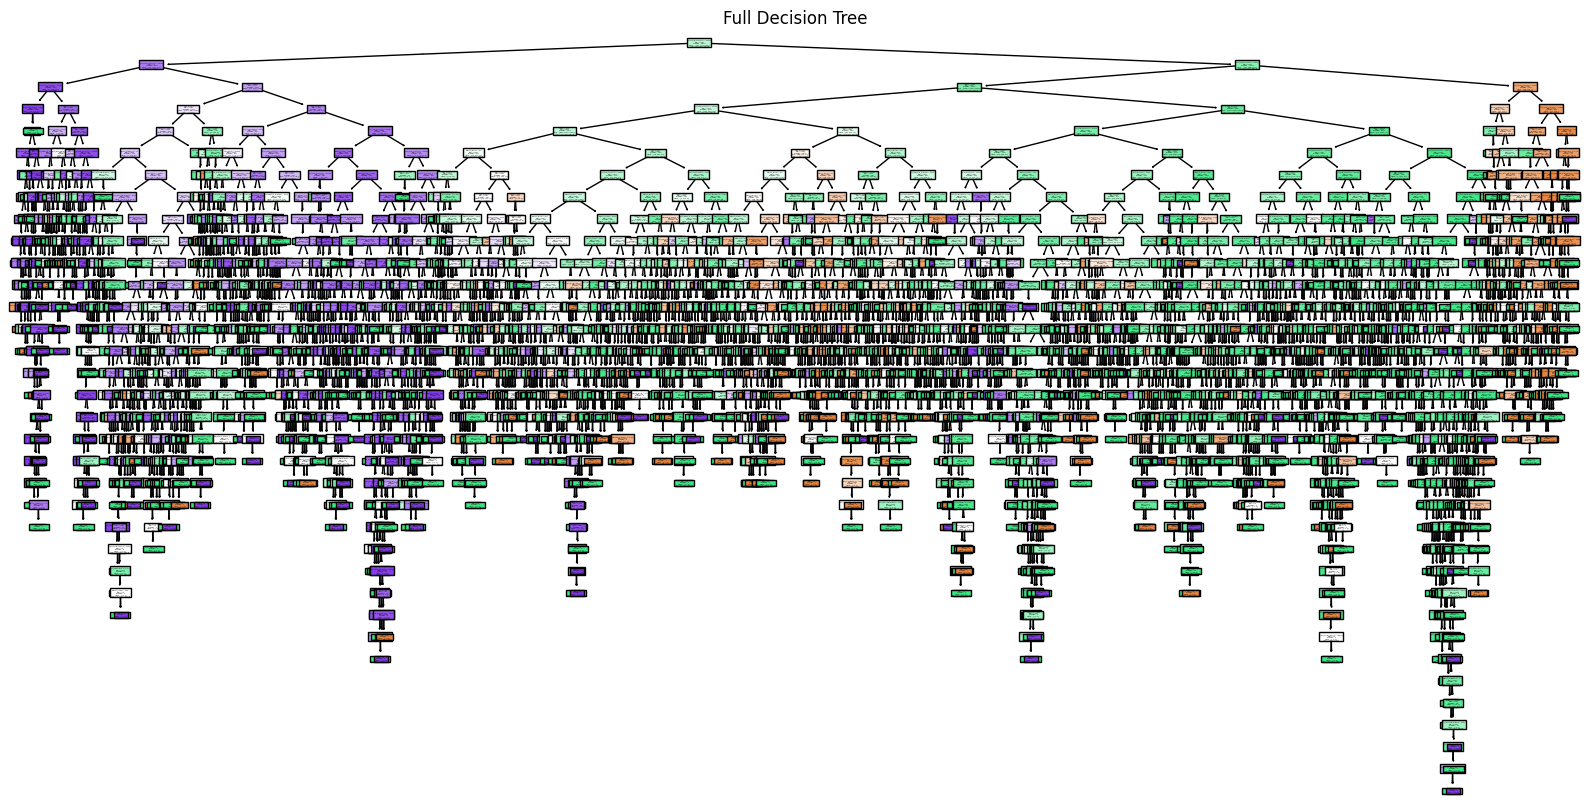

Reduced Decision Tree - Training Accuracy: 76.4 %
Reduced Decision Tree - Testing Accuracy: 74.0 %


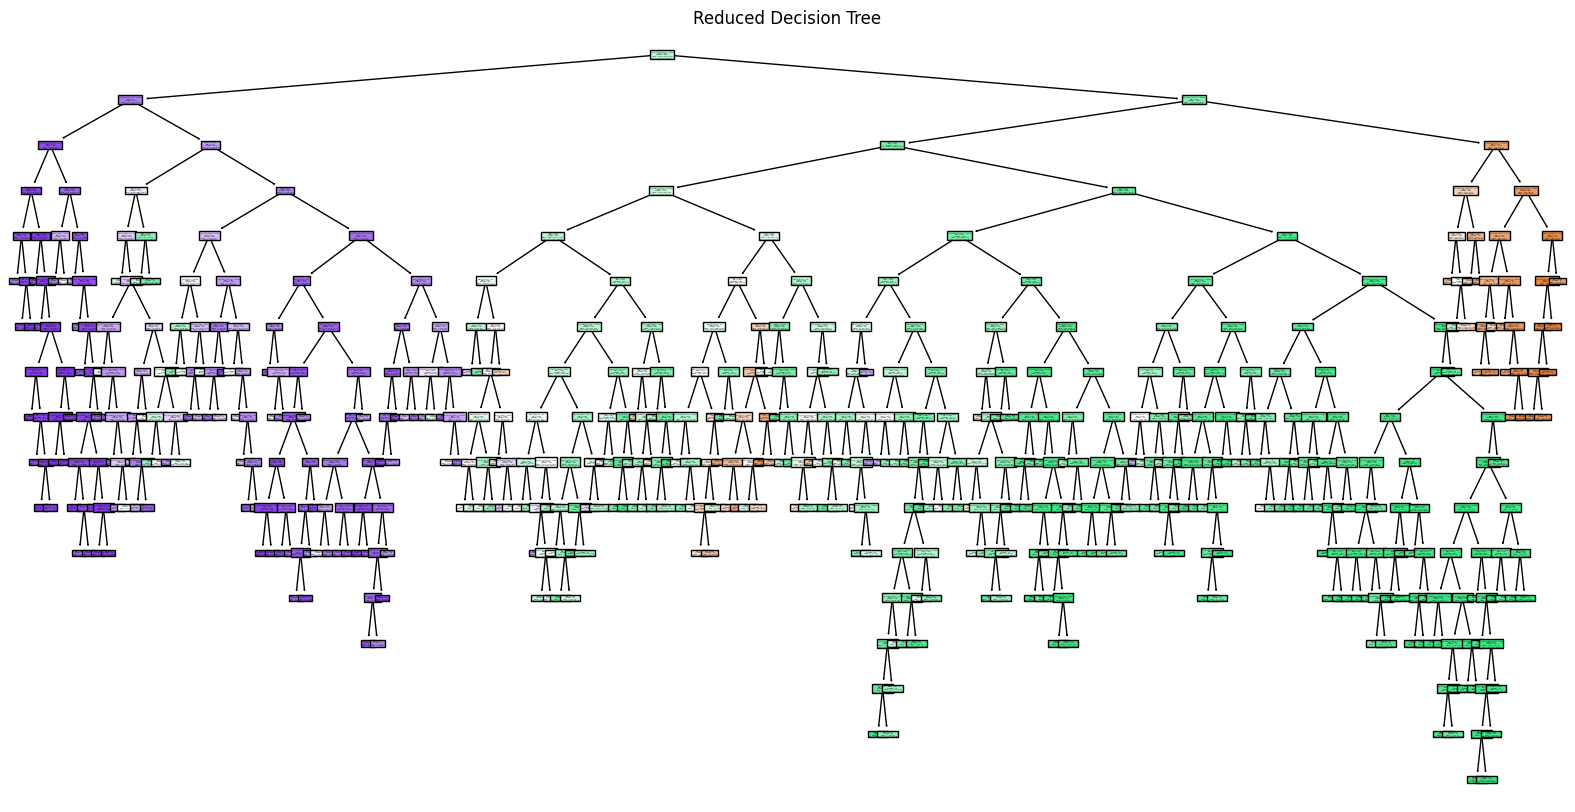

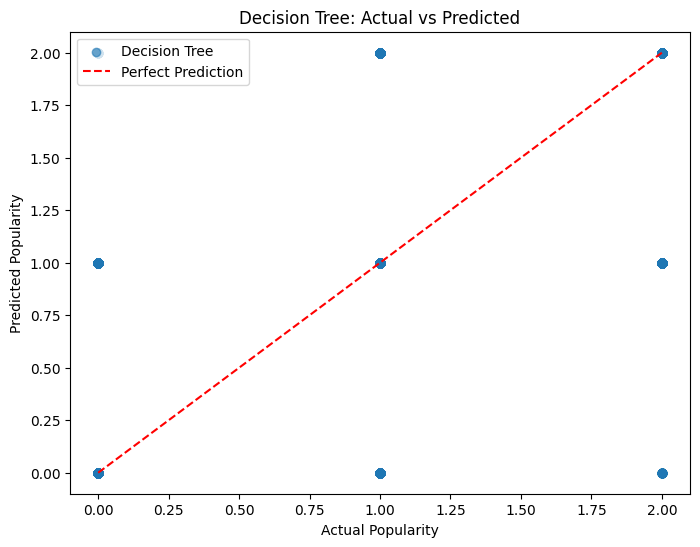

In [54]:
# Train Full Decision Tree
full_clf = DecisionTreeClassifier(random_state=42)
full_clf.fit(X_train, y_train)

# Cross-validation for Full Decision Tree
cv_scores_full_tree = cross_val_score(full_clf, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Scores for Full Decision Tree:", cv_scores_full_tree)
print("Mean CV Accuracy for Full Decision Tree:", round(cv_scores_full_tree.mean() * 100, 2), '%')

# Evaluate Full Decision Tree
y_pred_train = full_clf.predict(X_train)
y_pred_test = full_clf.predict(X_test)
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print('Decision Tree - Training Accuracy:', round(train_accuracy * 100, 1), '%')
print('Decision Tree - Testing Accuracy:', round(test_accuracy * 100, 1), '%')

# Confusion Matrix
print("Confusion Matrix on Training Data:")
print(confusion_matrix(y_train, y_pred_train))
print("Confusion Matrix on Testing Data:")
print(confusion_matrix(y_test, y_pred_test))

# Visualize Full Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    full_clf,
    filled=True,
    feature_names=X.columns,
    class_names=[str(cls) for cls in label_encoders['popularity_bin'].classes_]
)
plt.title('Full Decision Tree')
plt.show()

# Hyperparameter Tuning for Decision Tree
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [10, 20, 50]
}
gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
gridSearch.fit(X_train, y_train)

# Train Reduced Decision Tree
reduced_clf = DecisionTreeClassifier(
    max_depth=gridSearch.best_params_['max_depth'],
    min_samples_split=gridSearch.best_params_['min_samples_split'],
    min_samples_leaf=gridSearch.best_params_['min_samples_leaf'],
    random_state=42
)
reduced_clf.fit(X_train, y_train)

# Evaluate Reduced Decision Tree
y_pred_train_reduced = reduced_clf.predict(X_train)
y_pred_test_reduced = reduced_clf.predict(X_test)
train_accuracy_reduced = accuracy_score(y_train, y_pred_train_reduced)
test_accuracy_reduced = accuracy_score(y_test, y_pred_test_reduced)

print('Reduced Decision Tree - Training Accuracy:', round(train_accuracy_reduced * 100, 1), '%')
print('Reduced Decision Tree - Testing Accuracy:', round(test_accuracy_reduced * 100, 1), '%')

# Visualize Reduced Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(
    reduced_clf,
    filled=True,
    feature_names=X.columns,
    class_names=[str(cls) for cls in label_encoders['popularity_bin'].classes_]
)
plt.title('Reduced Decision Tree')
plt.show()

# Visualize Actual vs Predicted for Decision Tree
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_reduced, alpha=0.6, label='Decision Tree')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.legend()
plt.title('Decision Tree: Actual vs Predicted')
plt.show()

#### With Bagging

Bagged Decision Tree - Training Accuracy: 80.9 %
Bagged Decision Tree - Testing Accuracy: 76.4 %


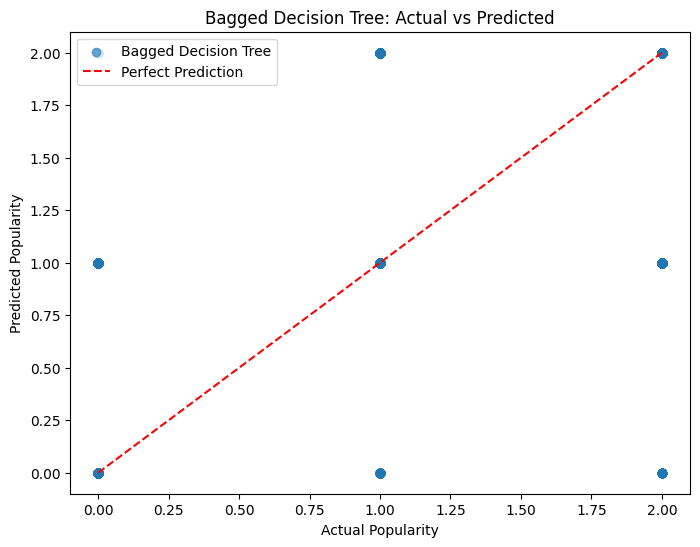

In [55]:
# Hyperparameter Tuning for Bagged Decision Tree
bagged_param_grid = {
    'estimator__max_depth': [10, 20, 30, None],
    'estimator__min_samples_split': [2, 10, 20],
    'estimator__min_samples_leaf': [1, 10, 20],
    'n_estimators': [50, 100, 200],
    'max_samples': [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0]
}

# Use estimator instead of base_estimator
bagged_gridSearch = RandomizedSearchCV(
    BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), random_state=42),  # Correct parameter
    param_distributions=bagged_param_grid,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit the grid search
bagged_gridSearch.fit(X_train, y_train)

# Train Best Bagged Decision Tree
best_bagged_dt = bagged_gridSearch.best_estimator_
best_bagged_dt.fit(X_train, y_train)

# Evaluate Bagged Decision Tree
y_pred_train_bagged = best_bagged_dt.predict(X_train)
y_pred_test_bagged = best_bagged_dt.predict(X_test)
train_accuracy_bagged = accuracy_score(y_train, y_pred_train_bagged)
test_accuracy_bagged = accuracy_score(y_test, y_pred_test_bagged)

print('Bagged Decision Tree - Training Accuracy:', round(train_accuracy_bagged * 100, 1), '%')
print('Bagged Decision Tree - Testing Accuracy:', round(test_accuracy_bagged * 100, 1), '%')

# Visualize Actual vs Predicted for Bagged Decision Tree
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_bagged, alpha=0.6, label='Bagged Decision Tree')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.legend()
plt.title('Bagged Decision Tree: Actual vs Predicted')
plt.show()

### 6. Random Forest

Random forests, an ensemble of decision trees, were implemented to improve predictions by averaging multiple models.

#### Steps
1. **Baseline Model**:
   - Hyperparameter tuning was performed for the number of trees, depth, and splitting criteria.
   - Evaluated accuracy, MSE, and R-squared.

2. **With Boosting**:
   - Used AdaBoost with the best random forest model to focus on harder-to-predict instances.
   - Compared performance to the baseline.


#### Baseline

Random Forest - Training Accuracy: 88.2 %
Random Forest - Testing Accuracy: 75.9 %
Random Forest - Training MSE: 0.15
Random Forest - Testing MSE: 0.28
Random Forest - Training R²: 0.65
Random Forest - Testing R²: 0.33


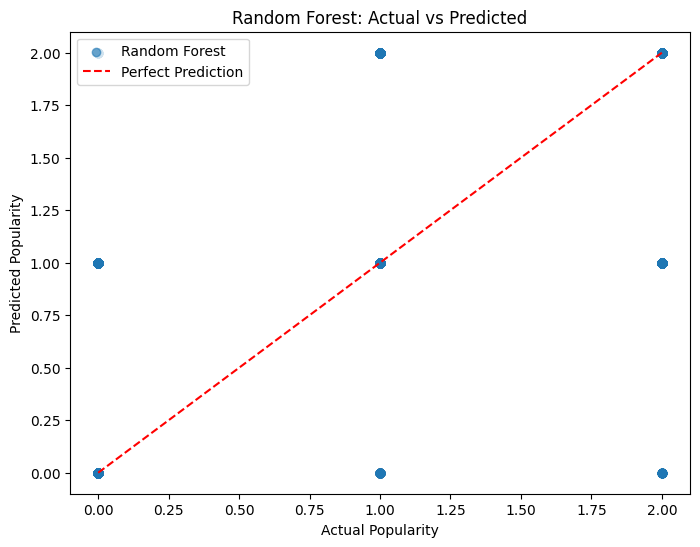

In [58]:
# Hyperparameter Tuning for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 10, 20]
}
rf_gridSearch = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_gridSearch.fit(X_train, y_train)

# Train Best Random Forest
best_rf = RandomForestClassifier(
    n_estimators=rf_gridSearch.best_params_['n_estimators'],
    max_depth=rf_gridSearch.best_params_['max_depth'],
    min_samples_split=rf_gridSearch.best_params_['min_samples_split'],
    min_samples_leaf=rf_gridSearch.best_params_['min_samples_leaf'],
    random_state=42
)
best_rf.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_train_rf = best_rf.predict(X_train)
y_pred_test_rf = best_rf.predict(X_test)

train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)

# Calculate MSE and R² for both train and test sets
train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)

train_r2_rf = r2_score(y_train, y_pred_train_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

# Print Accuracy, MSE, and R²
print('Random Forest - Training Accuracy:', round(train_accuracy_rf * 100, 1), '%')
print('Random Forest - Testing Accuracy:', round(test_accuracy_rf * 100, 1), '%')
print('Random Forest - Training MSE:', round(train_mse_rf, 2))
print('Random Forest - Testing MSE:', round(test_mse_rf, 2))
print('Random Forest - Training R²:', round(train_r2_rf, 2))
print('Random Forest - Testing R²:', round(test_r2_rf, 2))

# Visualize Actual vs Predicted for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_rf, alpha=0.6, label='Random Forest')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.legend()
plt.title('Random Forest: Actual vs Predicted')
plt.show()

24 24


<ipython-input-61-70d307971e2a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="crest")


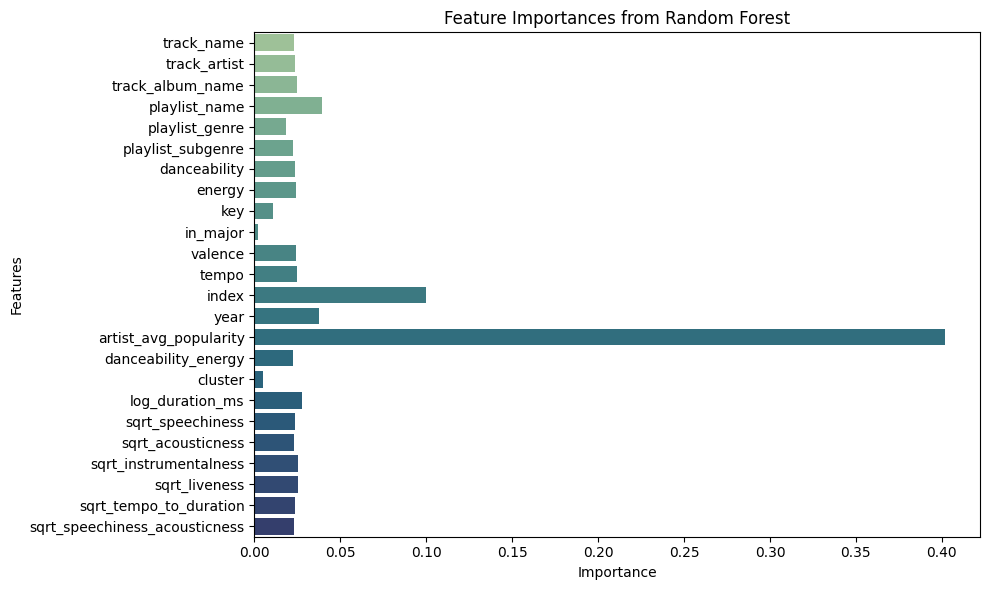

In [61]:
importances = best_rf.feature_importances_
features = X_train.columns  # Use X_train if that's what you trained on

# Confirm matching lengths
print(len(importances), len(features))  # These must match

# Now plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette="crest")
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

#### With Boosting

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Random Forest with Boosting - Training Accuracy: 99.9 %
Random Forest with Boosting - Testing Accuracy: 74.1 %
Random Forest with Boosting - Training MSE: 0.0
Random Forest with Boosting - Testing MSE: 0.32
Random Forest with Boosting - Training R²: 1.0
Random Forest with Boosting - Testing R²: 0.24


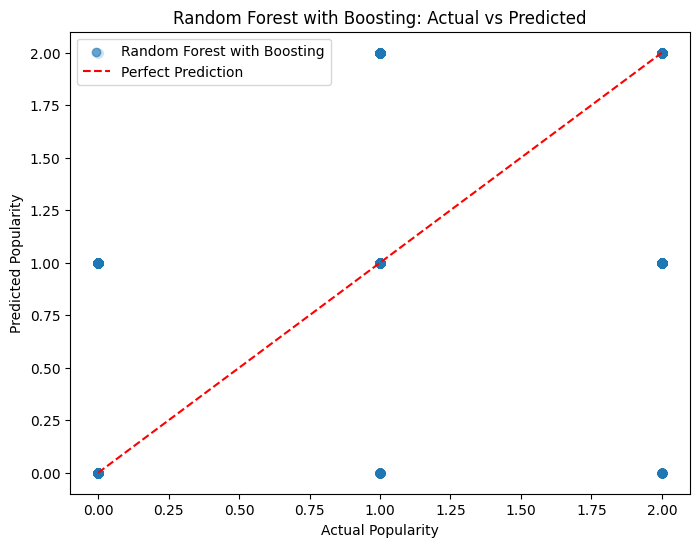

In [ ]:
# Hyperparameter Tuning for Random Forest with Boosting (AdaBoost)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 10, 20]
}

# Set up Random Forest GridSearch
rf_gridSearch = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_gridSearch.fit(X_train, y_train)

# Train Best Random Forest Model
best_rf = RandomForestClassifier(
    n_estimators=rf_gridSearch.best_params_['n_estimators'],
    max_depth=rf_gridSearch.best_params_['max_depth'],
    min_samples_split=rf_gridSearch.best_params_['min_samples_split'],
    min_samples_leaf=rf_gridSearch.best_params_['min_samples_leaf'],
    random_state=42
)

# Now use AdaBoost with the best Random Forest
boosted_rf = AdaBoostClassifier(estimator=best_rf, random_state=42, n_estimators=50)

# Fit the boosted model
boosted_rf.fit(X_train, y_train)

# Evaluate Random Forest with Boosting
y_pred_train_rf = boosted_rf.predict(X_train)
y_pred_test_rf = boosted_rf.predict(X_test)

# Training and Testing Accuracy
train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)

# Calculate MSE and R² for both train and test sets
train_mse_rf = mean_squared_error(y_train, y_pred_train_rf)
test_mse_rf = mean_squared_error(y_test, y_pred_test_rf)

train_r2_rf = r2_score(y_train, y_pred_train_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

# Print Accuracy, MSE, and R²
print('Random Forest with Boosting - Training Accuracy:', round(train_accuracy_rf * 100, 1), '%')
print('Random Forest with Boosting - Testing Accuracy:', round(test_accuracy_rf * 100, 1), '%')
print('Random Forest with Boosting - Training MSE:', round(train_mse_rf, 2))
print('Random Forest with Boosting - Testing MSE:', round(test_mse_rf, 2))
print('Random Forest with Boosting - Training R²:', round(train_r2_rf, 2))
print('Random Forest with Boosting - Testing R²:', round(test_r2_rf, 2))

# Visualize Actual vs Predicted for Random Forest with Boosting
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test_rf, alpha=0.6, label='Random Forest with Boosting')
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Popularity')
plt.ylabel('Predicted Popularity')
plt.legend()
plt.title('Random Forest with Boosting: Actual vs Predicted')
plt.show()